---

_This notebook has been modifie from the **version 1.0** of the cousera course 'Applied Machine Learning in Python
Applied Machine Learning in Python, University of Michigan'. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

### Content

* [Intro](#intro)
* [Naive Bayes classifiers](#NBC)
* [Ensambles of Decision Trees](#Ensambles)
    * [Random Forest](#RF)
    * [Gradient-boosted decision trees](#GBDT)
* [Neural Networks](#NN) 
    * [Material to revise](#revise)
* [Deep Learning](#deeplerning)    
    * [Material to revise](#revise2)
* [Data Leakage](#leakage)
    * [Material to revise](#revise3)


# Applied Machine Learning: Module 4 (Supervised Learning, Part II)

<a id="intro"></a> 
## Intro

This week we'll bring together the machine learning methods we've covered in previous weeks of this course, and discuss some important issues and best practices for how to apply these machine learning methods on real world problems. 

* You'll learn about how to perform feature engineering through developing and analyzing feature representations. 
* You'll understand the problem of data leakage. Why it's important and how to avoid it. 
* We'll discuss some useful rules for selecting the right machine learning approach for a given problem, and go over some best practices when integrating machine learning methods into software projects. 

<img src="module4_intro_1.png" alt="jupyter" style="width: 900px;"/> 

I'm going to summarize some of these examples of rules of thumb I've learned through my own work, as well as recommendations that other data scientists have shared with me. In the end, all of this will hopefully help you get the most out of applying machine learning in your projects. 

Let's first return to this diagram of the **iterative machine learning development proces ( Represent/Train/evaluate/Refine cycle for model development)**. We saw how developing a machine learning model involved four stages that could be repeated in a cycle, from *representing the data as a set of features to training a model, evaluating its performance on held out data, and then refining the features in the model to improve performance further by optimizing an objective*.

<img src="module4_intro_2.png" alt="jupyter" style="width: 900px;"/> 

Let's adjust this diagram slightly to reflect the fact that there is a set of processes that are **shared between the training and test stage and the prediction stage for future instances**. We've included a feature and model refinement stage here as part of the process but graded out to emphasize the shared series of processes that take data through the stages of **extraction, feature representation, application to a machine learning model, and evaluation. This series of processes is called, The Machine Learning Pipeline**. This Pipeline is used both with training and test instances during model development, and on future instances for prediction.

<img src="module4_intro_3.png" alt="jupyter" style="width: 900px;"/> 

We have the option of a refinement step either as the result of model development or as the result of deploying and evaluating the system on future data. Our focus this week will be on the **development phases** that are associated with a typical software project using machine learning and practice. 

<img src="module4_intro_4.png" alt="jupyter" style="width: 900px;"/> 

This involves three steps: setting up the initial end-to-end **pipelined infrastructure** to get something working and test the basic data extraction and manipulation processes, doing **feature engineering** to get useful features into the pipeline, and then a **refinement stage** to get feedback from evaluation that can be used to further improve the results. We'll cover some specifics of the feature engineering stage, as well as describe the problem of **data leakage when information about what we're trying to predict is accidentally present in the training data**. We'll also cover for each of these three development phases some software engineering rules of thumb that may help save you time and effort when deploying a real system. 

<img src="module4_intro_5.png" alt="jupyter" style="width: 900px;"/> 

## Preamble and Datasets

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_breast_cancer
from adspy_shared_utilities import load_crime_dataset


cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

# fruits dataset
fruits = pd.read_table('fruit_data_with_colors.txt')

feature_names_fruits = ['height', 'width', 'mass', 'color_score']
X_fruits = fruits[feature_names_fruits]
y_fruits = fruits['fruit_label']
target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

X_fruits_2d = fruits[['height', 'width']]
y_fruits_2d = fruits['fruit_label']

# synthetic dataset for simple regression
from sklearn.datasets import make_regression
plt.figure()
plt.title('Sample regression problem with one input variable')
X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                            n_informative=1, bias = 150.0,
                            noise = 30, random_state=0)
plt.scatter(X_R1, y_R1, marker= 'o', s=50)
plt.show()

# synthetic dataset for more complex regression
from sklearn.datasets import make_friedman1
plt.figure()
plt.title('Complex regression problem with one input variable')
X_F1, y_F1 = make_friedman1(n_samples = 100, n_features = 7,
                           random_state=0)

plt.scatter(X_F1[:, 2], y_F1, marker= 'o', s=50)
plt.show()

# synthetic dataset for classification (binary)
plt.figure()
plt.title('Sample binary classification problem with two informative features')
X_C2, y_C2 = make_classification(n_samples = 100, n_features=2,
                                n_redundant=0, n_informative=2,
                                n_clusters_per_class=1, flip_y = 0.1,
                                class_sep = 0.5, random_state=0)
plt.scatter(X_C2[:, 0], X_C2[:, 1], marker= 'o',
           c=y_C2, s=50, cmap=cmap_bold)
plt.show()

# more difficult synthetic dataset for classification (binary)
# with classes that are not linearly separable
X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2,
                       centers = 8, cluster_std = 1.3,
                       random_state = 4)
y_D2 = y_D2 % 2
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# Communities and Crime dataset
(X_crime, y_crime) = load_crime_dataset()

ModuleNotFoundError: No module named 'graphviz'

<a id="NBC"></a> 
## Naive Bayes classifiers

Another family of supervised learning models that's related to linear classification models is the **Naive Bayes family of classifiers, which are based on simple probabilistic models of how the data in each class might have been generated**. 

* Naive Bayes classifiers are called **naive because informally, they make the simplifying assumption that each feature of an instance is independent of all the others, given the class**. In practice, of course, this is not often the case, features often are somewhat correlated. For example, in predicting whether a house is likely to sell above the owner's asking price. Some features, such as the are of the interior rooms are likely to be correlated with other features, such as the size of the land that the house is built on or the number of bedrooms. And these features in turn might be correlated with the location of the property, and so on. 

* This naive simplifying assumption means on the one hand, that learning a Naive Bayes classifier is very fast. Because only simple per class statistics need to be estimated for each feature and applied for each feature independently. 

* On the other hand, the penalty for this efficiency is that the generalization performance of Naive Bayes Classifiers can often be a bit worse than other more sophisticated methods, or even linear models for classification. 

* Even so, especially for high dimensional data sets, Naive Bayes Classifiers can achieve performance that's often competitive to other more sophisticated methods, like support vector machines, for some tasks. 

<img src="module4_naive_bayes_1.png" alt="jupyter" style="width: 900px;"/> 

There are **three flavors of Naive Bayes Classifier** that are available in scikit learn. **The Bernoulli Naive Bayes** model uses a set of binary occurrence features. When classifying texts document for example, the Bernoulli Naive Bayes model is quit handy because we could represent the presence or the absence of the given word in the text with the binary feature. Of course this doesn't take into account how often the word occurs in the text. 

So the **Multinomial Naive Bayes** model uses a set of count base features each of which does account for how many times a particular feature such as a word is observed in training example like a document. In this lecture we won't have time to cover the Bernoulli or Multinomial Naive Bayes models. However, **those models are particularly well suited to textual data, where each feature corresponds to an observation for a particular word**. And so you'll see Naive Bayes again, including the Bernoulli and Multinomial models in more depth in the text mining part of this specialization. 

This lecture will focus on **Gaussian Naive Bayes classifiers** which assume features that are continuous or real-valued. During training, the Gaussian Naive Bayes Classifier estimates for each feature the mean and standard deviation of the feature value for each class. For prediction, the classifier compares the features of the example data point to be predicted with the feature statistics for each class, and selects the class that best matches the data point. 

More specifically, the **Gaussian Naive Bayes Classifier assumes that the data for each class was generated by a simple class specific Gaussian distribution**. Predicting the class of a new data point corresponds mathematically to estimating the probability that each classe's Gaussian distribution was most likely to have generated the data point. **Classifier then picks the class that has the highest probability**. 

<img src="module4_naive_bayes_2.png" alt="jupyter" style="width: 900px;"/> 

Without going into the mathematics involved, it can be shown that the decision boundary between classes in the two class Gaussian Naive Bayes Classifier. In general is a parabolic curve between the classes, and in the special case where the variance of these feature is the same for both classes. The decision boundary will be linear. 

<img src="module4_naive_bayes_3.png" alt="jupyter" style="width: 900px;"/> 

Here's what that looks like, typically, on a simple binary classification data set. The grey ellipses given idea of the shape of the Gaussian distribution for each class, as if we were looking down from above. You can see the centers of the Gaussian's correspond to the mean value of each feature for each class. 

More specifically, the grey ellipses show the contour line of the Gaussian distribution for each class, that corresponds to about two standard deviations from the mean. The line between the yellow and grey background areas represents the decision boundary. And we can see that this is indeed parabolic. 

<img src="module4_naive_bayes_4.png" alt="jupyter" style="width: 900px;"/> 

To use the Gaussian Naive Bayes classifier in Python, we just instantiate an instance of the Gaussian NB class and call the fit method on the training data just as we would with any other classifier. It's worth nothing that the **Naive Bayes models are among a few classifiers in scikit learn that support a method called partial fit**, which can be used instead of fit **to train the classifier incrementally** in case you're working with a huge data set that doesn't fit into memory. More details on that are available in the scikit learn documentation for Naive Bayes. 

For the Gaussian NB class **there are no special parameters to control the models complexity**. Looking at one example in the notebook from our synthetic two class dataset, we can see that, in fact, the Gaussian Naive Bayes classifier achieves quite good performance on this simple classification example. 

<IPython.core.display.Javascript object>


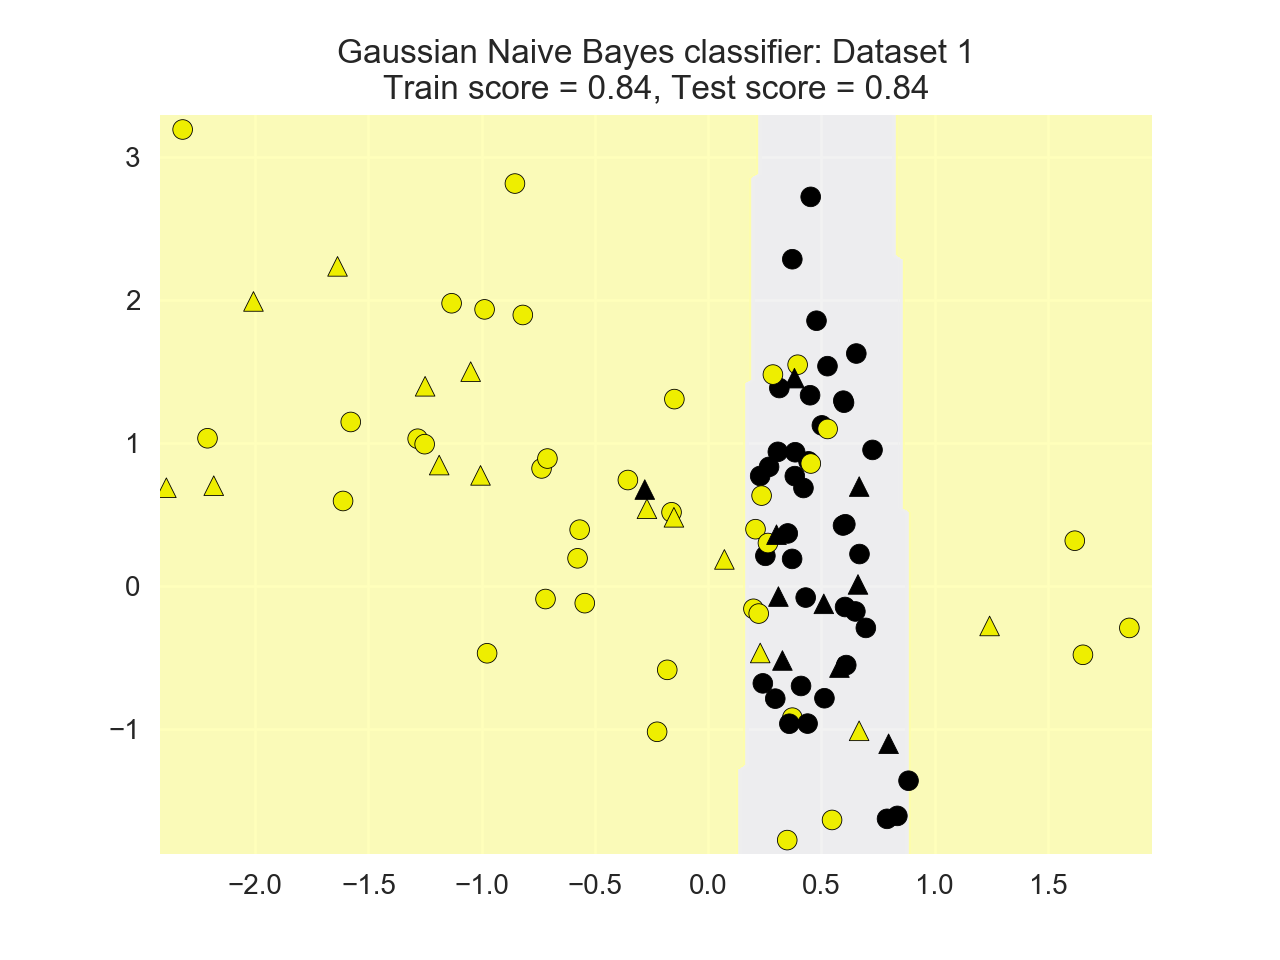

In [3]:
from sklearn.naive_bayes import GaussianNB
from adspy_shared_utilities import plot_class_regions_for_classifier

X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2, random_state=0)

nbclf = GaussianNB().fit(X_train, y_train)
plot_class_regions_for_classifier(nbclf, X_train, y_train, X_test, y_test,
                                 'Gaussian Naive Bayes classifier: Dataset 1')

When the classes are no longer as easily separable as with this second, more difficult binary example here. Like linear models, Naive Bayes does not perform as well. 

<IPython.core.display.Javascript object>


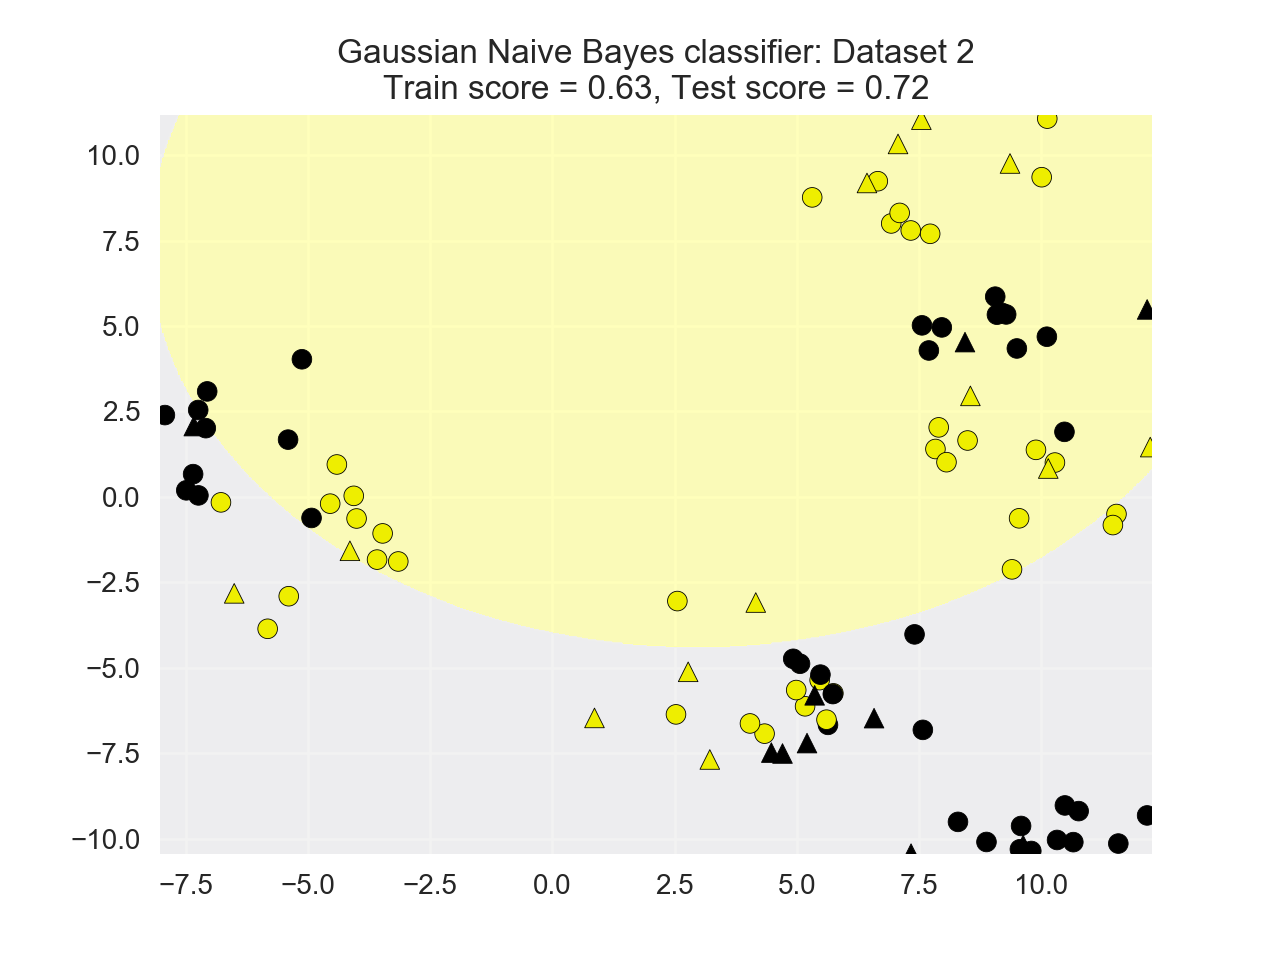

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2,
                                                   random_state=0)

nbclf = GaussianNB().fit(X_train, y_train)
plot_class_regions_for_classifier(nbclf, X_train, y_train, X_test, y_test,
                                 'Gaussian Naive Bayes classifier: Dataset 2')

### Application to a real-world dataset

On a real world example, using the breast cancer data set, the Gaussian Naive Bayes Classifier also does quite well, being quite competitive with other methods, such as support vector classifiers. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

nbclf = GaussianNB().fit(X_train, y_train)
print('Breast cancer dataset')
print('Accuracy of GaussianNB classifier on training set: {:.2f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

Breast cancer dataset
Accuracy of GaussianNB classifier on training set: 0.95
Accuracy of GaussianNB classifier on test set: 0.94


Typically, Gaussian Naive Bayes is used for high-dimensional data. When each data instance has hundreds, thousands or maybe even more features. And likewise the Bernoulli and Nultinomial flavors of Naive Bayes are used for text classification where there are very large number of distinct words is features and where the future vectors are sparse because any given document uses only a small fraction of the overall vocabulary. 

There's more in depth material on the Bernoulli and Multinomial Naive Bayes Classifiers in the text mining portion of this specialization. *It can be shown that Naive Bayes Classifiers are related mathematically to linear models, so many of the pros and cons of linear models also apply to Naive Bayes*. 

* On the **positive side Naive Bayes classifiers** are fast to train and use for prediction and thus are well suitable to high dimensional data including text. And the applications involving very large data sets where efficiency is critical and computational costs rule out other classification approaches. 

* On the **negative side**, when the conditional independence assumption about features doesn't hold. In other words, for a given class, there's significant covariance among features, as is the case with many real world datasets (strong correlation). Other more sophisticated classification methods that can account for these dependencies are likely to outperform Naive Bayes. On a side note, when getting confidence or probability estimates associated with predictions, Naive Bayes classifiers produce unreliable estimates, typically. 

Still, Naive Bayes Classifiers can perform very competitively on some tasks, and are also **often very useful as baseline models against which more sophisticated models can be compared**. 

<img src="module4_naive_bayes_5.png" alt="jupyter" style="width: 900px;"/> 

<a id="Ensambles"></a> 

## Ensembles of Decision Trees

A widely used and effective method in machine learning involves creating learning models known as **ensembles**. An ensemble **takes multiple individual learning models and combines them to produce an aggregate model that is more powerful than any of its individual learning models alone**. Why are ensembles effective? Well, one reason is that if we have different learning models, although each of them might perform well individually, they'll tend to make different kinds of mistakes on the data set. And typically, this happens because each individual model might overfit to a different part of the data. By combining different individual models into an ensemble, we can average out their individual mistakes to reduce the risk of overfitting while maintaining strong prediction performance. **Random forests** are an example of the ensemble idea applied to decision trees.

<a id="RF"></a> 
### Random forests

Random forests are widely used in practice and achieve very good results on a wide variety of problems. They can be used as **classifiers** via the sklearn ```RandomForestClassifier``` class or for **regression** using the ```RandomForestRegressor``` class both in the sklearn ensemble module. 

As we saw earlier, **one disadvantage of using a single decision tree was that decision trees tend to be prone to overfitting the training data**. As its name would suggest, a **random forest creates lots of individual decision trees on a training set, often on the order of tens or hundreds of trees. The idea is that each of the individual trees in a random forest should do reasonably well at predicting the target values in the training set but should also be constructed to be different in some way from the other trees in the forest**. Again, as the name would suggest this difference is accomplished by introducing random variation into the process of building each decision tree.


<img src="module4_RandomForest_1.png" alt="jupyter" style="width: 900px;"/> 

 This **random variation during tree building happens in two ways. First, the data used to build each tree is selected randomly and second, the features chosen in each split tests are also randomly selected**. To create a random forest model you first decide on how many trees to build. This is set using the ```n_estimated``` parameter for both ```RandomForestClassifier``` and ```RandomForestRegressor```. 
 
<img src="module4_RandomForest_2.png" alt="jupyter" style="width: 900px;"/> 

Each tree was built from a different random sample of the data called the **bootstrap sample**. Bootstrap samples are commonly used in statistics and machine learning. If your training set has *N instances* or samples in total, **a bootstrap sample of size *N* is created by just repeatedly picking one of the N dataset rows at random with replacement, that is, allowing for the possibility of picking the same row again at each selection**. You repeat this random selection process *N* times. The resulting bootstrap sample has *N* rows just like the original training set but with possibly some rows from the original dataset missing and others occurring multiple times just due to the nature of the random selection with replacement. 

<img src="module4_RandomForest_3.png" alt="jupyter" style="width: 900px;"/> 

When building a decision tree for a random forest, the process is almost the same as for a standard decision tree but with one important difference. **When picking the best split for a node, instead of finding the best split across all possible features, a random subset of features is chosen and the best split is found within that smaller subset of features**. The number of features in the subset that are randomly considered at each stage is controlled by the max_features parameter. 

<img src="module4_RandomForest_4.png" alt="jupyter" style="width: 900px;"/> 

This randomness in selecting the bootstrap sample to train an individual tree in a forest ensemble, combined with the fact that splitting a node in the tree is restricted to random subsets of the features of the split, virtually guarantees that all of the decision trees and the random forest will be different. 

* The random forest model is quite sensitive to the ```max_features``` parameter. 


* ```max_features``` is set to one, the random forest is limited to performing a split on the single feature that was selected randomly instead of being able to take the best split over several variables. This means the trees in the forest will likely be very different from each other and possibly with many levels in order to produce a good fit to the data. 

* On the other hand if ```max_features``` is high, close to the total number of features that each instance has, the trees in the forest will tend to be similar and probably will require fewer levels to fit the data using the most informative features. 

<img src="module4_RandomForest_5.png" alt="jupyter" style="width: 900px;"/> 

* Once a random forest model is trained, it **predicts the target** value for new instances by first making a prediction for every tree in the random forest. 

* For *regression* tasks the overall *prediction is then typically the mean of the individual tree predictions*. 

* For *classification* the overall *prediction is based on a weighted vote*. 
    * Each tree gives a probability for each possible target class label.
    * Then the probabilities for each class are averaged across all the trees.
    * And the class with the highest probability is the final predicted class. 

<img src="module4_RandomForest_6.png" alt="jupyter" style="width: 900px;"/> 

<IPython.core.display.Javascript object>


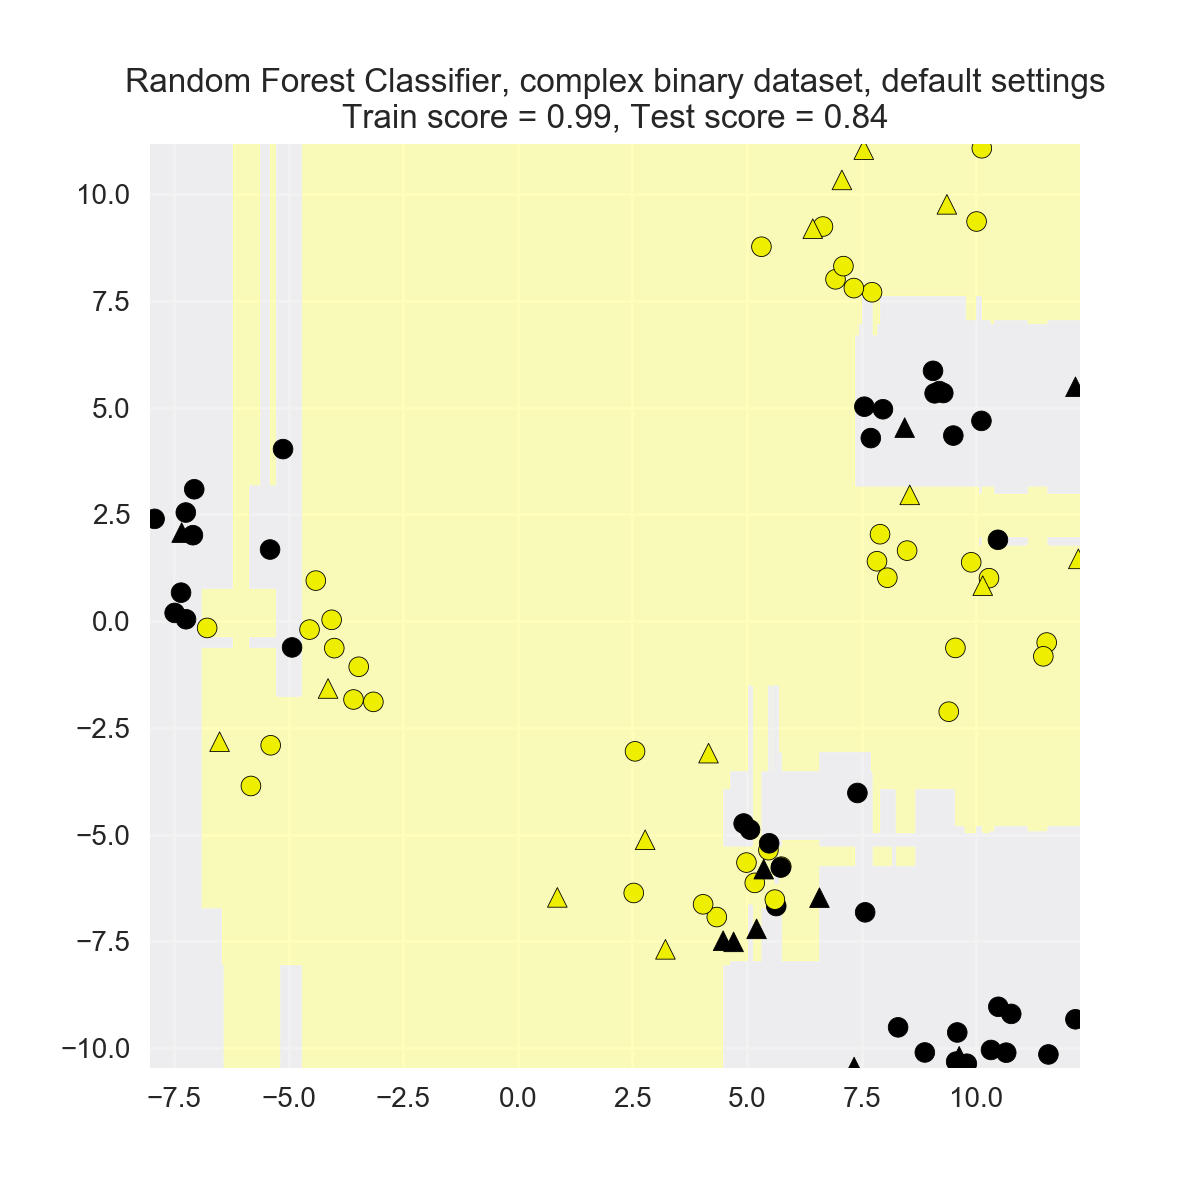

In [7]:
# Synthetic dataset for classification (binary)
# with classes that are not linearly separable

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2,
                                                   random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = RandomForestClassifier().fit(X_train, y_train)
title = 'Random Forest Classifier, complex binary dataset, default settings'
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, X_test,
                                         y_test, title, subaxes)

plt.show()

### Random forest: Fruit dataset

Here's an example of learning a random forest of the example fruit dataset using two features, *height* and *width*. Here we're showing the training data plotted in terms of two feature values with *height* on the x axis and *width* on the y axis. As usual, there are four categories of fruit to be predicted. Because the number of features is restricted to just two in this very simple example, *the randomness in creating the tree ensemble is coming mostly from the bootstrap sampling of the training data*. You can see that the decision boundaries overall have the box like shape that we associate with decision trees but with some additional detail variation to accommodate specific local changes in the training data. Overall, you can get an impression of the increased complexity of this random forest model in capturing both the global and local patterns in the training data compared to the single decision tree model we saw earlier.

<img src="module4_RandomForest_7.png" alt="jupyter" style="width: 600px;"/> 

Let's take a look at the notebook code that created and visualized this random forest on the fruit dataset. This code also plots the decision boundaries for the other five possible feature pairs. Again, to use the RandomForestClassifier we import the random forest classifier class from the sklearn ensemble library. After doing the usual train test split and setting up the pipe plot figure for plotting, we iterate through pairs of feature columns in the dataset. For each pair of features we call the fit method on that subset of the training data X using the labels y. We then use the utility function plot class regions for classifier that's available in the shared module for this course to visualize the training data and the random forest decision boundaries. 

<IPython.core.display.Javascript object>


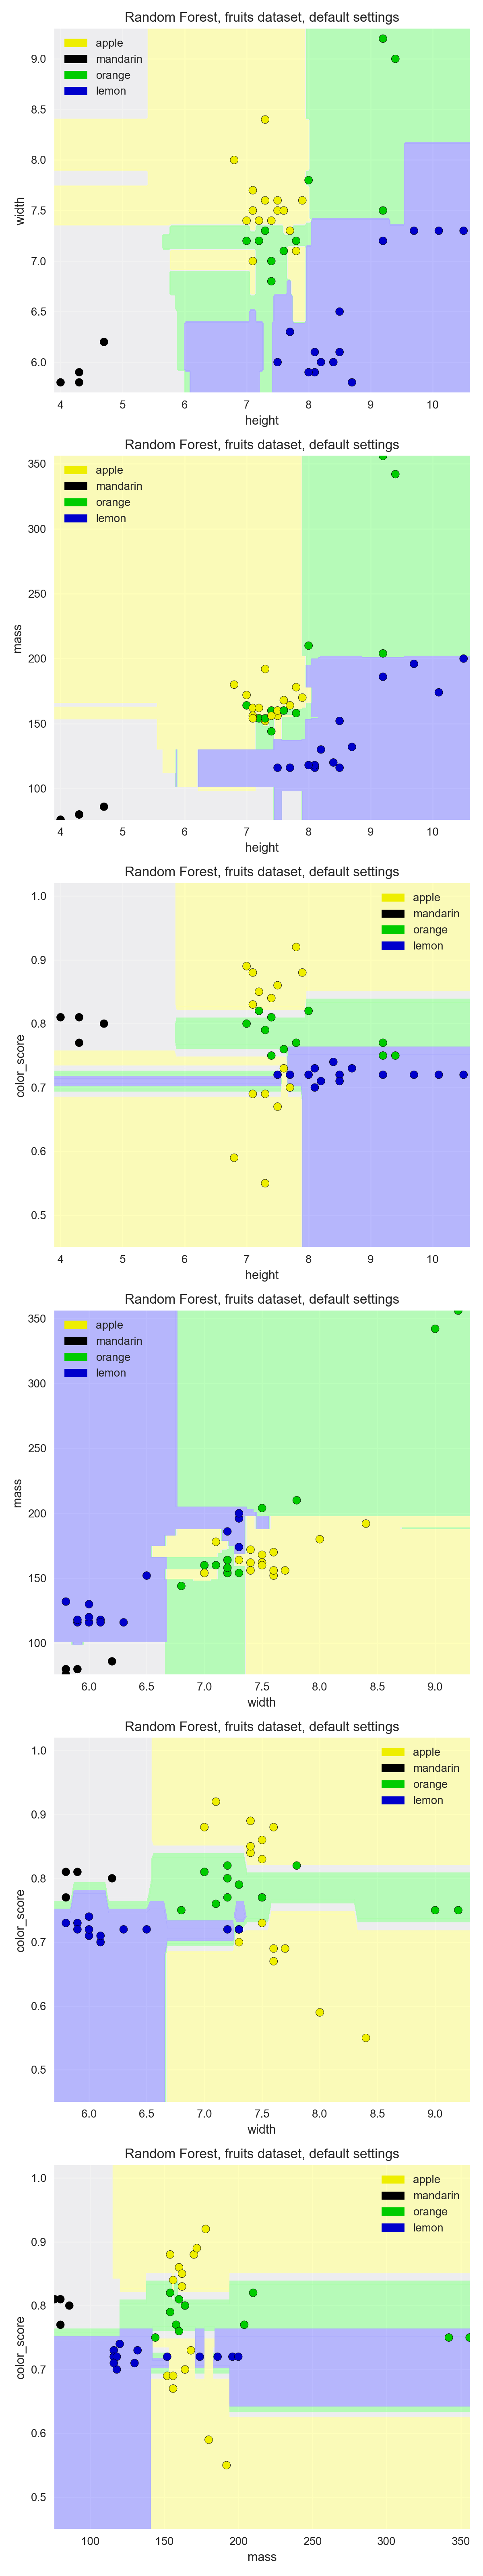

Random Forest, Fruit dataset, default settings
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.80


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_fruits.as_matrix(),
                                                   y_fruits.as_matrix(),
                                                   random_state = 0)
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

title = 'Random Forest, fruits dataset, default settings'
pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = RandomForestClassifier().fit(X, y)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             target_names_fruits)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
        
plt.tight_layout()
plt.show()

clf = RandomForestClassifier(n_estimators = 10,
                            random_state=0).fit(X_train, y_train)

print('Random Forest, Fruit dataset, default settings')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

#### Random Forests on a real-world dataset

Let's apply random forest to a larger dataset with more features. For comparison with other supervised learning methods, we use the breast cancer dataset again. We create a new random forest classifier and since there are about 30 features, we'll set ```max_features``` to eight to give a diverse set of trees that also fit the data reasonably well. We can see that random forest with no feature scaling or extensive parameter tuning achieve very good test set performance on this dataset, in fact, it's as good or better than all the other supervised methods we've seen so far including current life support vector machines and neural networks that require more careful tuning. Notice that **we did not have to perform scaling or other pre-processing as we did with a number of other supervised learning methods. This is one advantage of using random forests. Also note that we passed in a fixed value for the random state parameter in order to make the results reproducible**. If we didn't set the random state parameter, the model would likely be different each time due to the randomized nature of the random forest algorithm. 

In [11]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = RandomForestClassifier(max_features = 8, random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.99


* So, on the **positive side**, random forest are widely used because they're very powerful. They give excellent prediction performance on a wide variety of problems and they don't require careful scaling of the feature data or extensive parameter tuning. And even though building many different trees requires a corresponding increase in computation, building random forests is easily paralyzed across multiple CPU's. 

* On the **negative side** while random forests do inherit many of the benefits of decision trees, one big difference is that random forest models can be very difficult for people to interpret making it difficult to see the predictive structure of the features or to know why a particular prediction was made. In addition, random forests are not a good choice for tasks that have very high dimensional sparse features like text classification, where linear models can provide efficient training and fast accurate prediction. 

<img src="module4_RandomForest_8.png" alt="jupyter" style="width: 600px;"/> 


So to recap, here are some of the key parameters that you'll need for using random forests:

* **n_estimators** sets the number of trees to use. The default value for ```n_estimators``` is 10 and increasing this number for larger data sets is almost certainly a good idea since ensembles that can average over more trees will reduce overfitting. Just bear in mind that increasing the number of trees in the model will also increase the computational cost of training. You'll use more time and more memory. So in practice you'll want to choose the parameters that make best use of the resources available on your system. 

* As we saw earlier, the **max_features** parameter has a strong effect on performance. It has a large influence on how diverse the random trees in the forest are. Typically, the default setting of ```max_features```, which for **classification** is the **square root of the total number of features** and for **regression is the log base two of the total number of features**, works quite well in practice although explicitly adjusting ```max_features``` may give you some additional performance gain with smaller values of ```max_features``` tending to reduce overfitting. 

* The **max_depth** parameter controls the depth of each tree in the ensemble. The default setting for this is ```None```, in other words, the nodes in a tree will continue to be split until all leaves contain the same class or have fewer samples than the minimum sample split parameter value, which is two by default. 

* Most systems now have a multi-core processor and so you can use the **n_jobs** parameter to tell the random forest algorithm how many cores to use in parallel to train the model. Generally, you can expect something close to a linear speed up. So, for example, if you have four cores, the training will be four times as fast as if you just used one. If you set end jobs to negative one it will use all the cores on your system and setting **n_jobs** to a number that's more than the number of cores on your system won't have any additional effect. 

* Finally, given the random nature of random forests, if you want reproducible results it's especially important to choose a **fixed setting for the random state parameter**. In the examples we've shown here we typically set random state to zero but any fixed number will work just as well. 

<img src="module4_RandomForest_9.png" alt="jupyter" style="width: 600px;"/> 


<a id="GBDT"></a> 
### Gradient-boosted decision trees

Another tree based ensemble method that's gain wide use in real world application is **gradient boosted decision trees**. Like random forest, gradient boosted trees used an ensemble of multiple tress to create more powerful prediction models for classification and regression. 

In this lecture, we'll provide a brief overview of gradient boosted decision trees, along with the discussion of their key parameters, the control model complexity. **Unlike the random forest method that builds and combines a forest of randomly different trees in parallel, the key idea of gradient boosted decision trees is that they build a series of trees. Where each tree is trained, so that it attempts to correct the mistakes of the previous tree in the series**. 

Typically, gradient boosted tree ensembles use lots of shallow trees known in machine learning as weak learners. **Built in a nonrandom way, to create a model that makes fewer and fewer mistakes as more trees are added**. Once the model is built, making predictions with a gradient boosted tree models is fast and doesn't use a lot of memory. Like random forests, the number of estimators in the gradient boosted tree ensemble is an important parameter in controlling model complexity. 

A new parameter that does not occur with random forest is something called the **learning rate. The learning rate controls how the gradient boost the tree algorithms, builds a series of collective trees. When the learning rate is high, each successive tree put strong emphases on correcting the mistakes of its predecessor, and thus may result in a more complex individual tree, and those overall are more complex model. With smaller settings of the learning rate, there's less emphasis on thoroughly correcting the errors of the previous step, which tends to lead to simpler trees at each step**. 

<img src="module4_gbdt_1.png" alt="jupyter" style="width: 600px;"/> 

Here's an example showing how to use gradient boosted trees in scikit-learn on our sample fruit classification test, plotting the decision regions that result. The code is more or less the same as what we used for random forests. But from the sklearn.ensemble module, we import the GradientBoostingClassifier class. We then create the GradientBoostingClassifier object, and fit it to the training data in the usual way. By default, the learning rate parameter is set to 0.1, the ```n_estimators``` parameter giving the number of trees to use is set to 100, and the ```max_depth``` is set to 3. As with random forests, you can see the decision boundaries have that box-like shape that's characteristic of decision trees or ensembles of trees. 

<IPython.core.display.Javascript object>


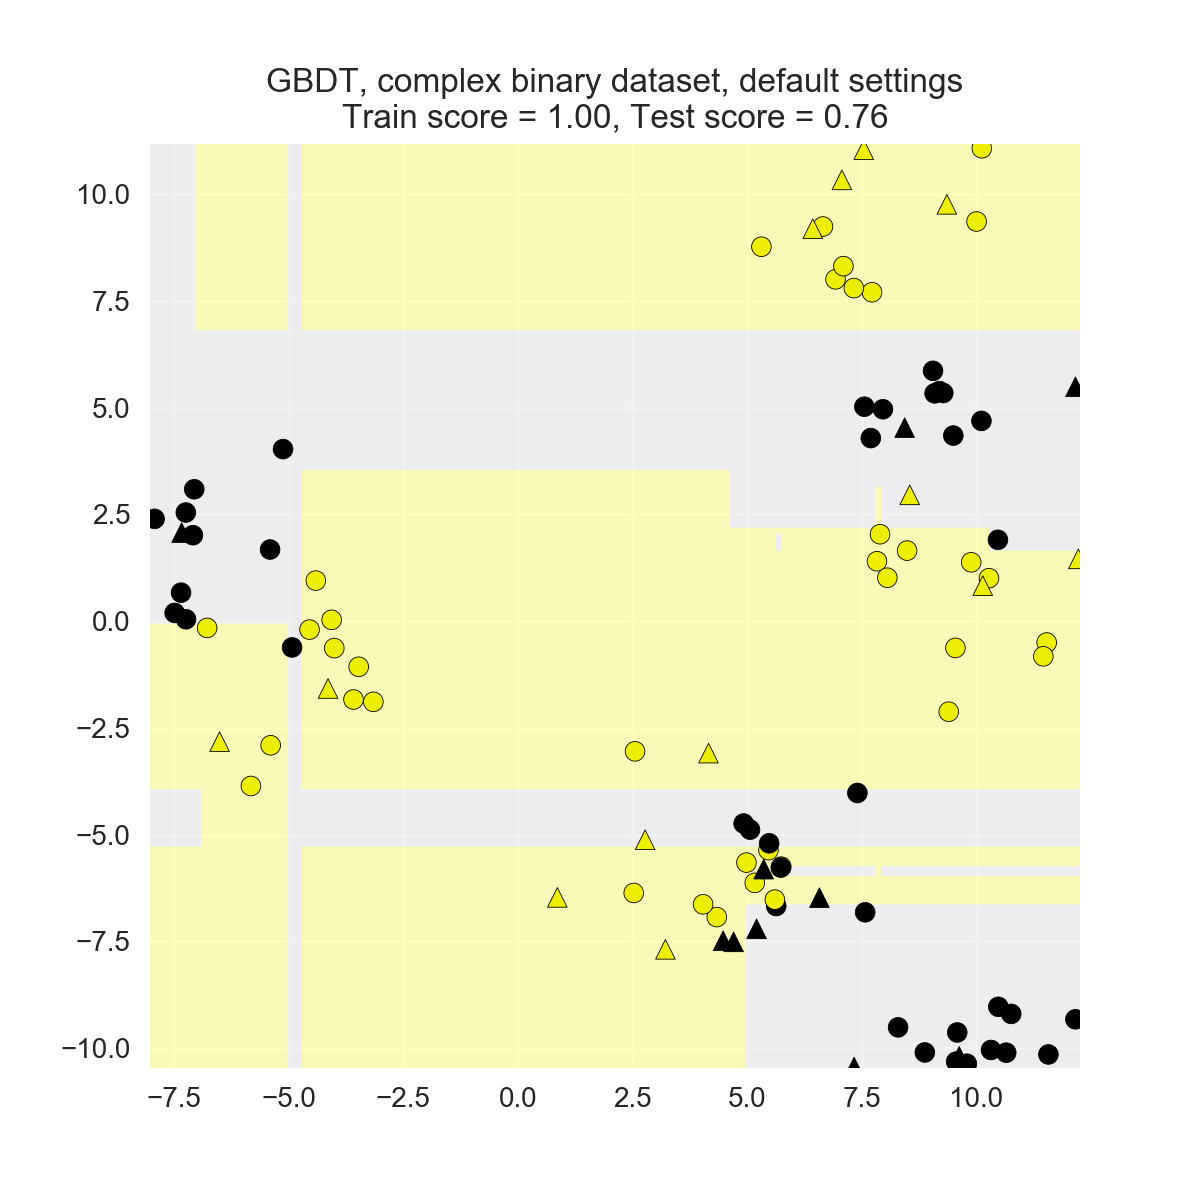

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = GradientBoostingClassifier().fit(X_train, y_train)
title = 'GBDT, complex binary dataset, default settings'
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, X_test,
                                         y_test, title, subaxes)

plt.show()

#### Gradient boosted decision trees on the fruit dataset

<IPython.core.display.Javascript object>


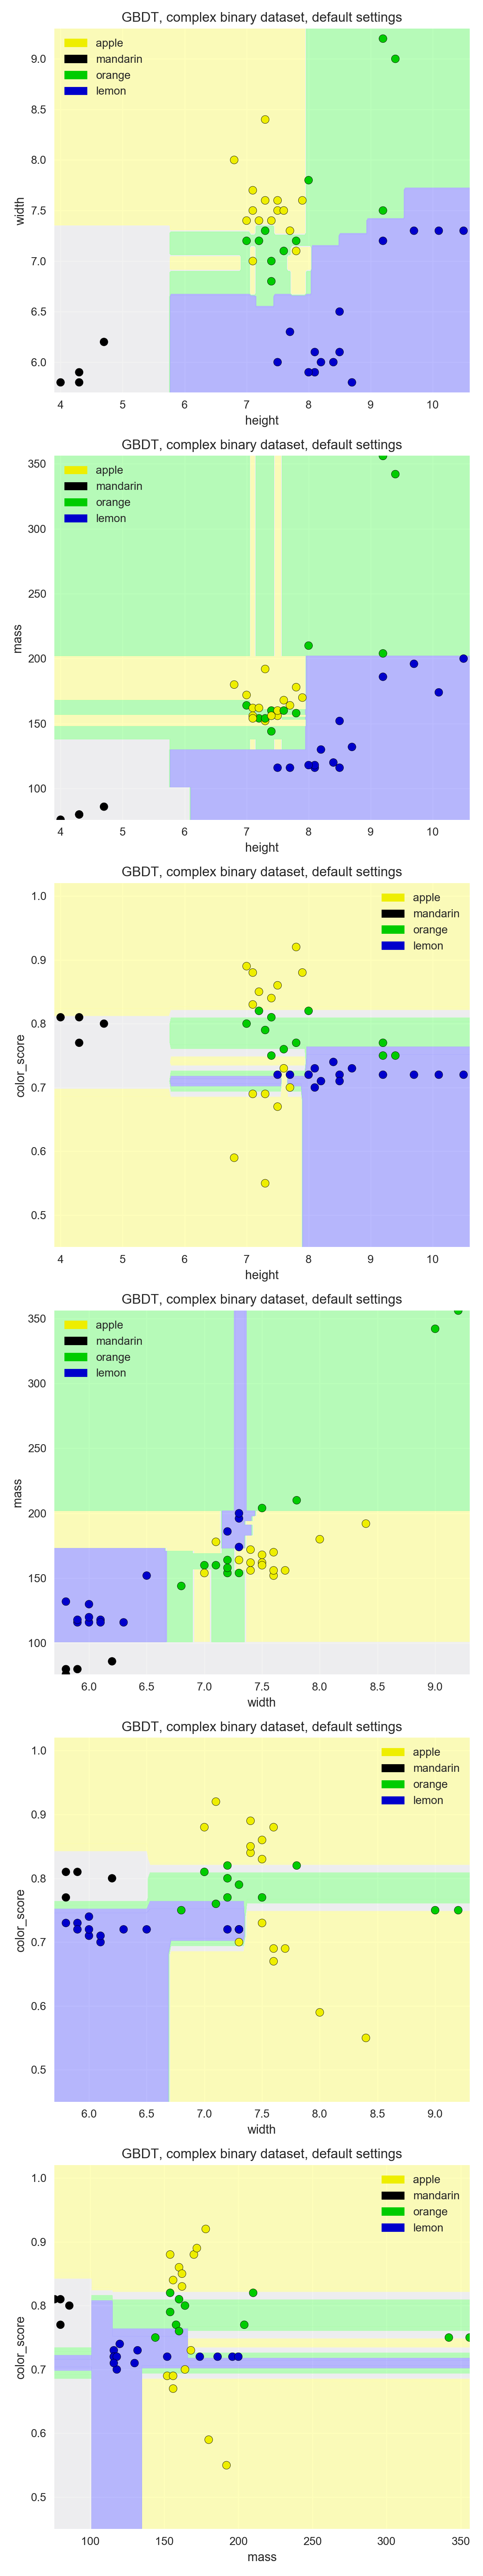

GBDT, Fruit dataset, default settings
Accuracy of GBDT classifier on training set: 1.00
Accuracy of GBDT classifier on test set: 0.80


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_fruits.as_matrix(),
                                                   y_fruits.as_matrix(),
                                                   random_state = 0)
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = GradientBoostingClassifier().fit(X, y)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             target_names_fruits)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
    
plt.tight_layout()
plt.show()
clf = GradientBoostingClassifier().fit(X_train, y_train)

print('GBDT, Fruit dataset, default settings')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

#### Gradient-boosted decision trees on a real-world dataset

Now let's apply gradient boosted decision trees to the breast cancer dataset. This code trains two different gradient boosted classifiers. The first one uses the default settings. We can see that the first result has perfect accuracy on the training set, which indicates the model is likely overfitting. 

Two ways to learn a less complex gradient boosted tree model are, to reduce the learning rate, so that each tree doesn't try as hard to learn a more complex model, that fixes the mistakes of its predecessor. And to reduce the ```max_depth``` parameter for the individual trees in the ensemble. The second classifier example makes these changes in the parameters. And you can see, that the training set accuracy does decrease, while the test set accuracy increases slightly. 

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = GradientBoostingClassifier(random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset (learning_rate=0.1, max_depth=3)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}\n'
     .format(clf.score(X_test, y_test)))

clf = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset (learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset (learning_rate=0.1, max_depth=3)
Accuracy of GBDT classifier on training set: 1.00
Accuracy of GBDT classifier on test set: 0.96

Breast cancer dataset (learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.97
Accuracy of GBDT classifier on test set: 0.97


* Gradient boosted decision trees are among the best off-the-shelf supervised learning methods available. Achieving excellent accuracy with only modest memory and runtime requirements to perform prediction, once the model has been trained. Some major commercial applications of machine learning have been based on gradient boosted decision trees. 
Like other decision tree based learning methods, you don't need to apply feature scaling for the algorithm to do well and the futures can be a mix of binary, categorical and continuous types. 

* Boosted decision trees do have several downsides. So like random forests, ensembles of trees are very difficult for people to interpret, compared to individual decision trees. However, this often may not matter for many applications where prediction accuracy is the most important goal. Gradient boosted methods can require careful tuning of the learning rate and other parameters. And **the training process can require a lot of computation**. And like the other tree based methods we saw, it is not recomended to use gradient boosted methods for text classification or other scenarios. Where the featured space has thousands of features with sparse values, is usually not a good choice for accuracy and computational cost reasons. 

<img src="module4_gbdt_2.png" alt="jupyter" style="width: 600px;"/> 


* The key parameters controlling model complexity for gradient boosted tree models are, ```n_estimators``` which sets the number of small decisions trees the week learns to use in the ensemble.

* The learning rate. (Typically, these two parameters are tuned together. Since making the learning rates smaller, will require more trees to maintain model complexity). 

* Unlike random forest, increasing an ```n_estimators``` can lead to overfitting. So typically, the ```n_estimators``` setting is chosen to best exploit the speed and memory capabilities of the system during the training. And other parameters like the learning rate are then adjusted, given that fixed an ```n_estimators``` setting. 

* The ```max_depth``` parameter can also have an effect of model complexity by controlling the depth, and has a complexity of the individual trees. The gradient boosting method assumes, that each trees is a weak learner, and so the ```max_depth``` parameter is usually quite small, on the order of three to five, for most applications. 

<img src="module4_gbdt_3.png" alt="jupyter" style="width: 600px;"/> 


<a id="NN"></a> 

## Neural networks

In this part of the course, you'll get an introduction to the basics of neural networks (NN). Which are a broad family of algorithms that have formed the basis for the recent resurgence in the computational field called deep learning. Early work on neural networks actually began in the 1950s and 60s. And just recently, has experienced a resurgence of interest, as deep learning has achieved impressive state-of-the-art results. On specific tasks that range from object classification in images, to fast accurate machine translation, to gameplay. 

The topic of neural networks requires its own course. And indeed, if you're interested in more depth, you can check out the excellent course on Coursera. Called Neural Networks for Machine Learning, by a pioneer in this area, Professor Geoffrey Hinton. 

Here, we'll provide an introduction to the basic concepts and algorithms that are foundation of neural networks. And of the much more sophisticated deep learning methods in use today. You'll learn about some basic models called **multi-layer perceptrons**, supported by scikit-learn, that can be used for **classification and regression**. 

Let's start by briefly reviewing simpler methods we have already seen for regression and classification. Linear regression and logistic regression, which we show graphically here. **Linear regression predicts a continuous output, $\widehat{y}$**, shown as the box on the right. As a function of the sum of the input variables $x_i$, shown in the boxes on the left. Each *weighted* by a corresponding coefficient, $\widehat{w_i}$, plus an intercept or bias term, $\widehat{b}$. We saw how various methods like ordinary least squares, ridge regression or lasso regression could be used to estimate these model coefficients, $\widehat{w_i}$ and $\widehat{b}$, shown above the arrows in the diagram, from training data. 

**Logistic regression takes this one step further, by running the output of the linear function of the input variables, $x_i$ through an additional nonlinear function, the logistic function**. Represented by the new box in the middle of the diagram, to produce the output, $\widehat{y}$. Which, because of the logistic function, is now constrained to lie between 0 and 1. We use logistical regression for binary classification since we can interpret  $\widehat{y}$ as the probability that a given input data instance belongs to the positive class, in a two-class binary classification scenario. 

<img src="module4_NN_1.png" alt="jupyter" style="width: 600px;"/> 


Here's an example of a simple **neural network for regression, called a multi-layer perceptron**. Which I will sometimes abbreviate by **MLP**. These are also known as feed-forward neural networks. MLPs take this idea of computing weighted sums of the input features, like we saw in logistic regression. But it takes it a step beyond logistic regression, by adding an additional processing step called a hidden layer represented by this additional set of boxes, $h_0$, $h_1$, and $h_2$ in the diagram. These boxes, within the hidden layer, are called hidden units and each hidden unit in the hidden layer computes a nonlinear function (activation fuction) of the weighted sums of the input features resulting in intermediate output values, $v_0$, $v_1$, $v_2$. Then the MLP computes a weighted sum of these hidden unit outputs, to form the final output value, $\widehat{y}$. 

<img src="module4_NN_2.png" alt="jupyter" style="width: 600px;"/> 

This nonlinear function that the hidden unit applies is called the **activation function**. In this example, your activation function is the hyperbolic tangent function, which is related to the logistic function. You can see that the result of adding this additional hidden layer processing step to the prediction model, is a formula for $\widehat{y}$ that is already more involved than the one for logistic regression. Now predicting $\widehat{y}$ involves computing a different initial weighted sum of the input feature values for each hidden unit. Which applies a nonlinear activation function and all of these nonlinear outputs are combined using another weighted sum to produce $\widehat{y}$. In particular, there's one weight between each input and each hidden unit and one weight between each hidden unit and the output variable. In fact, this addition and combination of non-linear activation functions allows multi-layer perceptrons to learn more complex functions than is possible with a simple linear or logistic function. This additional expressive power enables neural networks to perform more accurate prediction when the relationship between the input and output is itself complex. Of course, this complexity also means that there are a lot more weights, model coefficients, to estimate in the training phase which means that both more training data and more computation are typically needed to learn in a neural network, compared to a linear model. 

<img src="module4_NN_3.png" alt="jupyter" style="width: 600px;"/> 

As an aside, **there are a number of choices for the activation function in a neural network**, that gets applied in hidden units. Here, the plot shows the input value coming into the activation function, from the previous layer's inputs on the x-axis. And the y-axis shows the resulting output value for the function. This code to plot this example is available in the accompanying notebook. The three main activation functions we'll compare later in this lecture are the **hyperbolic tangent**; that's the S-shaped function in green. The **rectified linear unit function (ReLu)** shown as the piecewise linear function in blue. The familiar **logistic function**, which is shown in red. The *relu* activation function is the default activation function for neural networks in scikit-learn. It maps any negative input values to zero. The hyperbolic tangent function, or tanh function maps large positive input values to outputs very close to 1, and large negative input values, to outputs very close to -1. These differences in the activation function can have some effect on the shape of regression prediction plots or classification decision boundaries that neural networks learn. In general, we'll be using either the hyperbolic tangent or the relu function as our default activation function since these perform well for most applications. 

<img src="module4_NN_4.png" alt="jupyter" style="width: 600px;"/> 


#### Activation functions

<IPython.core.display.Javascript object>


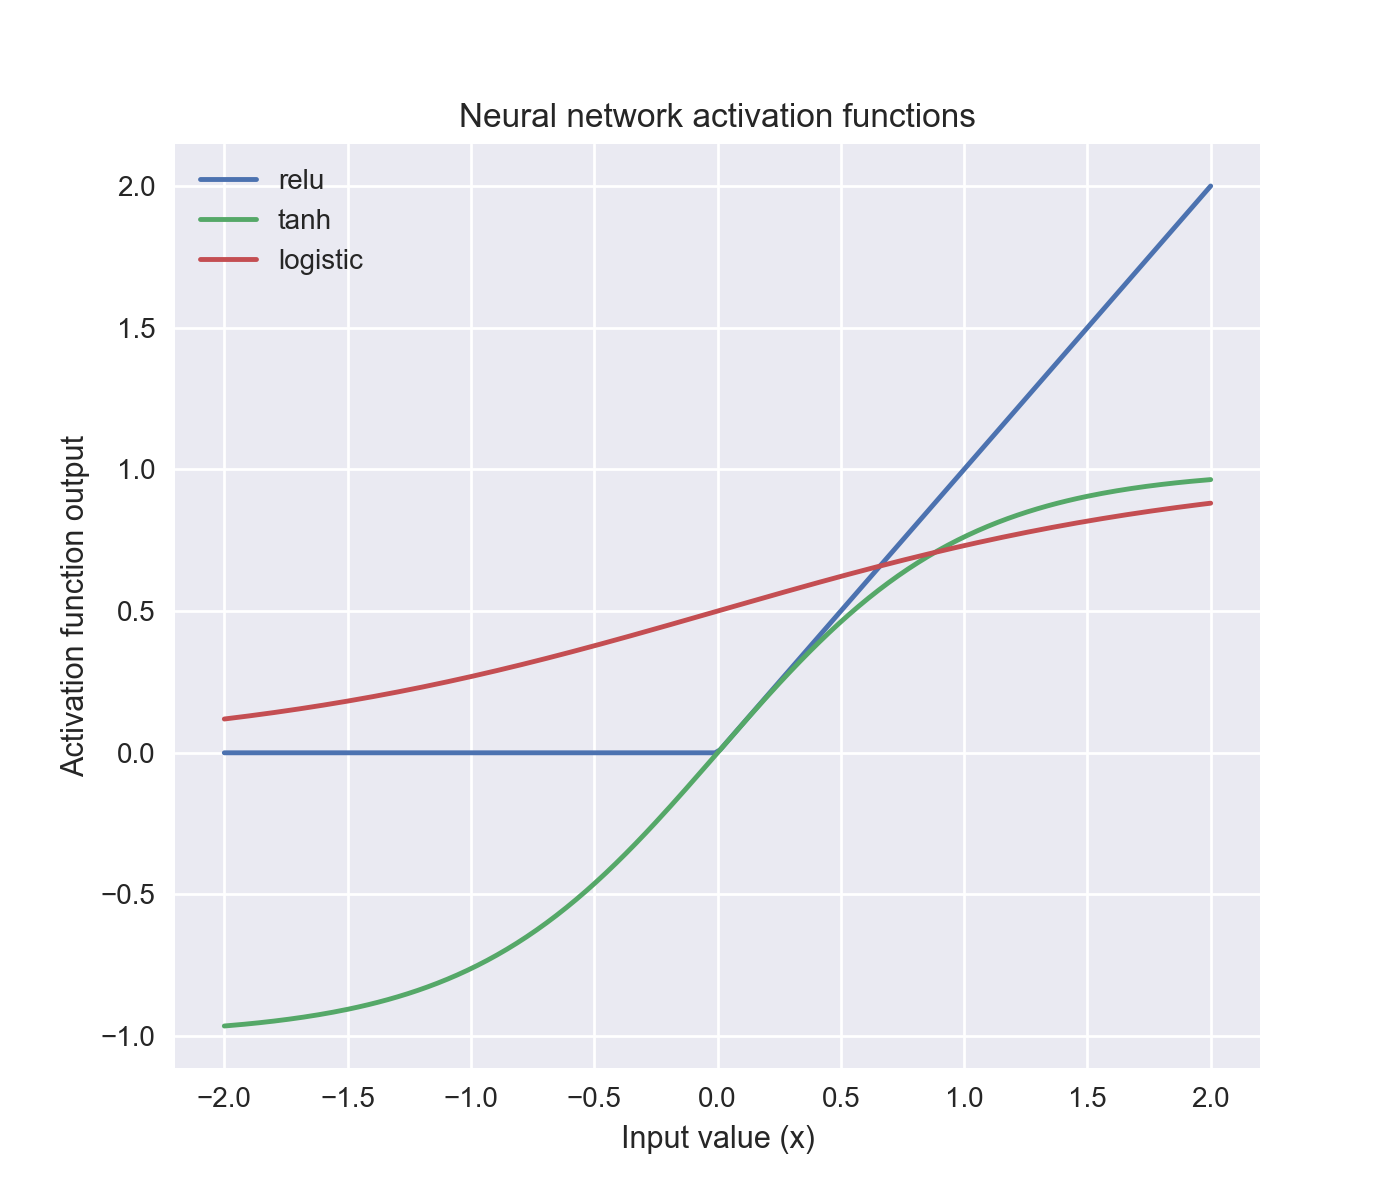

In [18]:
xrange = np.linspace(-2, 2, 200)

plt.figure(figsize=(7,6))

plt.plot(xrange, np.maximum(xrange, 0), label = 'relu')
plt.plot(xrange, np.tanh(xrange), label = 'tanh')
plt.plot(xrange, 1 / (1 + np.exp(-xrange)), label = 'logistic')
plt.legend()
plt.title('Neural network activation functions')
plt.xlabel('Input value (x)')
plt.ylabel('Activation function output')

plt.show()

### Neural networks: Classification


Let's take a look at how we use neural networks in scikit-learn for classification. Using the more complex synthetic binary classification data set. 

To use a neural network classifier, you import the ``MLPClassifier`` class from the sklearn.neural_network module. This code example shows the classifier being fit to the training data, using a single hidden layer. With three different numbers of hidden units in the layer, 1 unit, 10 units and 100 units. As with all other classification types we've seen, you can create the classifier objects with the appropriate parameters. And call the fit method on the training data. 

Here, the main parameter for a neural network classifier is this parameter, ```hidden_layer_sizes```. This parameter is a list, with one element for each hidden layer, that gives the number of hidden units to use for that layer. So here we're passing a list with a single element. Meaning we want one hidden layer, using the number in the variable called units. By default, if you don't specify the hidden_layer_sizes parameter, scikit-learn will create a single hidden layer with 100 hidden units. While a setting of 10 may work well for simple data sets, like the one we use as examples here. For really complex data sets, the number of hidden units could be in the thousands. It's also possible, as we'll see shortly, to create an MLP with more than one hidden layer. By passing a hidden_layer_sizes parameter with multiple entries. 

I want to also note the use of this extra parameter, called ```solver```, which specifies the algorithm to use for learning the weights of the network. Here, we're using the *lbfgs* algorithm. We'll discuss the solver parameter setting further, at the end of this lecture. Also note that we're passing in a ```random_state parameter```, when creating the ```MLPClassifier object``` like we did for the train-test split function and we happened to set this random state parameter to a fixed value of zero. This is because for neural networks, their weights are initialized randomly, which can affect the model that is learned. Because of this, even without changing the key parameters on the same data set the same neural network algorithm might learn two different models depending on the value of the internal random seed that is chosen. So by always setting the same value for the random seed used to initialize the weights we can assure the results will always be the same, for everyone using these examples. 


#### Synthetic dataset 1: single hidden layer

<IPython.core.display.Javascript object>


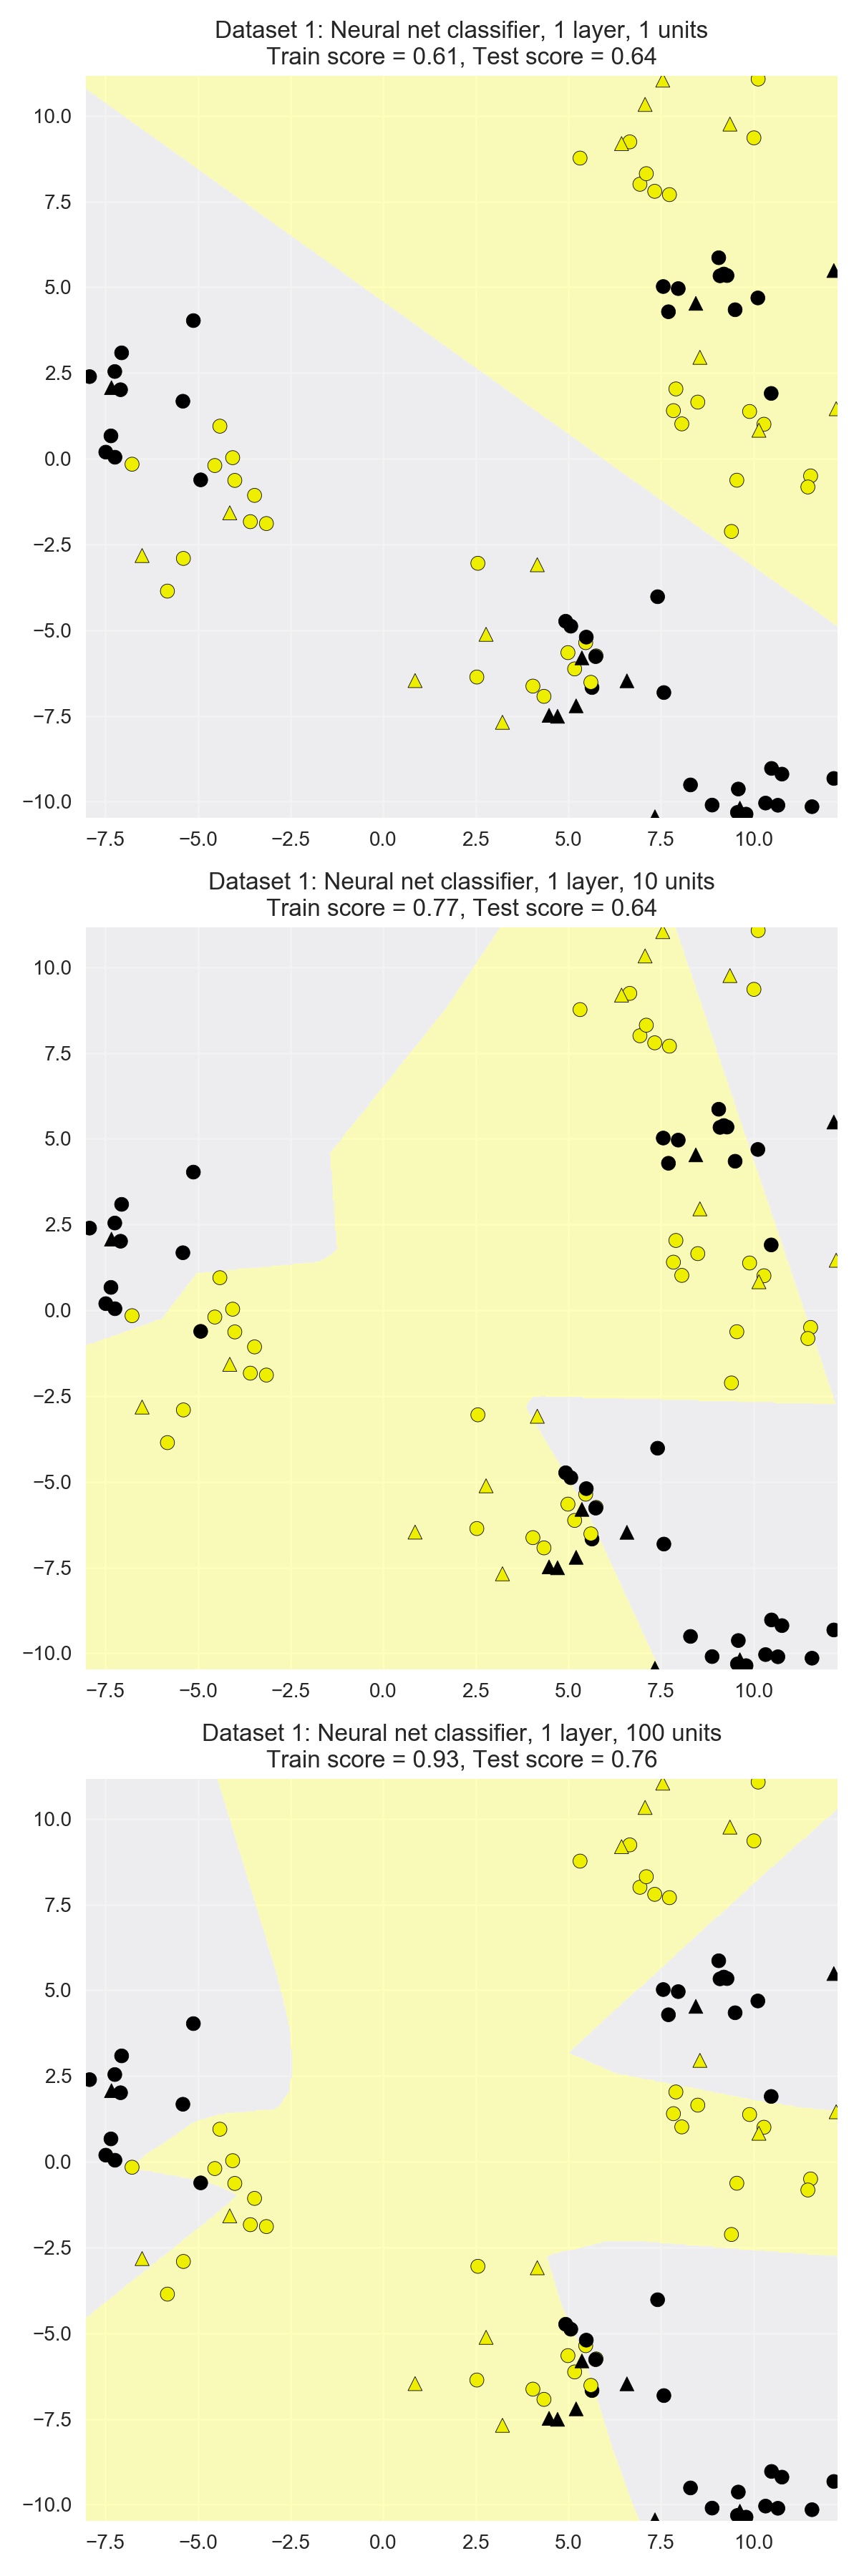

In [20]:
from sklearn.neural_network import MLPClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

for units, axis in zip([1, 10, 100], subaxes):
    nnclf = MLPClassifier(hidden_layer_sizes = [units], solver='lbfgs',
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

This graphic plots the results of running this code. To show how the number of hidden units in a single layer in the neural network affects the model complexity for classification. With a single hidden unit, the model is mathematically equivalent to logistic regression. We see the classifier returns the familiar simple linear decision boundary between the two classes. The training set score's low, and the test score is not much better, so this network model is under-fitting. With ten hidden units, we can see that the ```MLPClassifier``` is able to learn a more complete decision boundary. That captures more of the nonlinear, cluster-oriented structure in the data, though the test set accuracy is still low. With 100 hidden units, the decision boundary is even more detailed. And achieves much better accuracy, on both the training and the test sets. 

<img src="module4_NN_5.png" alt="jupyter" style="width: 600px;"/> 

Here's a graphical depiction of a **multi-layer perceptron with two hidden layers**. Adding the second hidden layer further increases the complexity of functions that the neural network can learn, from more complex data sets. Taking this complexity further, **large architectures of neural networks, with many stages of computation, are why deep learning methods are called deep**. And we'll summarize deep learning, in an upcoming lecture for this week. 

<img src="module4_NN_6.png" alt="jupyter" style="width: 600px;"/> 

Here is an example in the notebook, showing how we create a two-layer MLP, with 10 hidden units in each layer. We just set the **hidden_layer_sizes parameter**, when creating the ```MLPClassifier``` to a two-element list. Indicating ten units, in each of the two hidden layers. You can see the result of of adding the second hidden layer, on the classification problem we saw earlier. On the left is the original MLP, with one hidden layer of ten units, and on the right is the same data set, using a new MLP with two hidden layers of ten units each. You can see the MLP with two hidden layers learned a more complex decision boundary. And achieved, in this case, a much better fit on the training data, and slightly better accuracy on the test data. 

<img src="module4_NN_7.png" alt="jupyter" style="width: 600px;"/> 


#### Synthetic dataset 1: two hidden layers

<IPython.core.display.Javascript object>


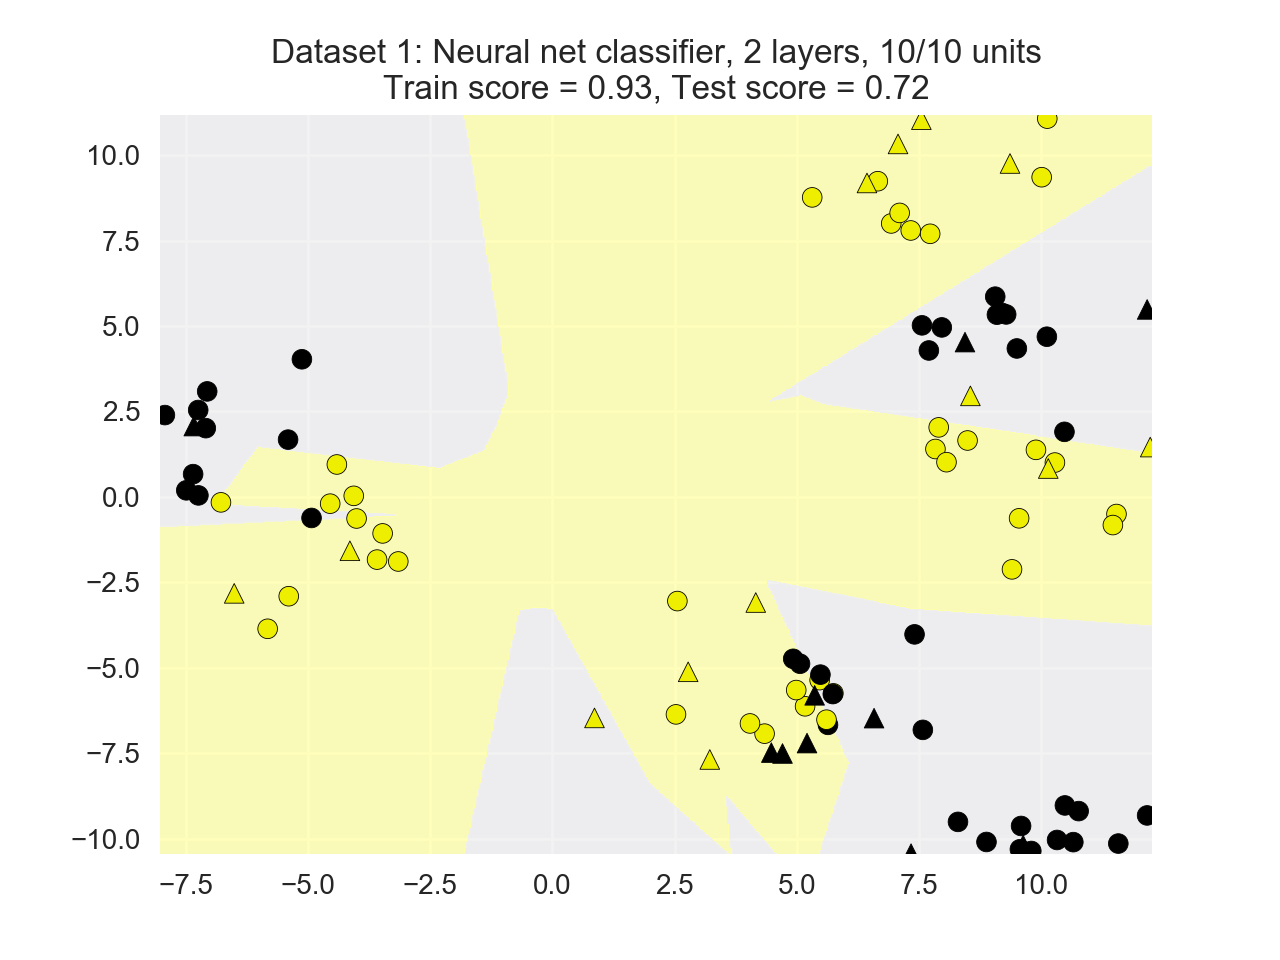

In [21]:
from adspy_shared_utilities import plot_class_regions_for_classifier

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

nnclf = MLPClassifier(hidden_layer_sizes = [10, 10], solver='lbfgs',
                     random_state = 0).fit(X_train, y_train)

plot_class_regions_for_classifier(nnclf, X_train, y_train, X_test, y_test,
                                 'Dataset 1: Neural net classifier, 2 layers, 10/10 units')

#### Regularization parameter: alpha

Once we start adding more hidden layers, with lots of hidden units, you can see that the number of weights, or model coefficients to estimate for a neural network can increase rapidly. So that more complex neural networks could have many thousands of weights to estimate. We can control this model complexity, just as we did with Ridge and LASSO regression by adding an L2 regularization (Ridge) penalty on the weights. **Remember that L2 regularization penalizes models that have a large sum of squares of all the weight values with the effect being, that the neural network prefers models with more weights shrunk close to zero**. 

The regularization parameter for MLPs is called $\alpha$, like with the linear regression models. And in scikit-learn, it's set to a small value by default, like 0.0001, that gives a little bit of regularization. This code example shows the effects of changing $\alpha$ for a larger MLP, with 2 hidden layers of 100 nodes each. From a small value of 0.01, to a larger value of 5.0. For variety here, we're also setting the activation function to use the *hyperbolic tangent function*. Here's the graphical output of this notebook code. You can see the effect of increasing regularization with increasing $\alpha$. 

In the left plot, **when $\alpha$ is small, the decision boundaries are much more complex and variable**. And the classifier's over-fitting, as we can see from the very high training set score, and low test score. On the other hand, the right plot uses the largest value of $\alpha$ here, $\alpha$ 5.0. And that setting results in much smoother decision boundaries, while still capturing the global structure of the data. And this increased simplicity allows it to generalize much better, and not over-fit to the training set. And this is evident from the much higher test score, in this case. 

<img src="module4_NN_8.png" alt="jupyter" style="width: 600px;"/> 



<IPython.core.display.Javascript object>


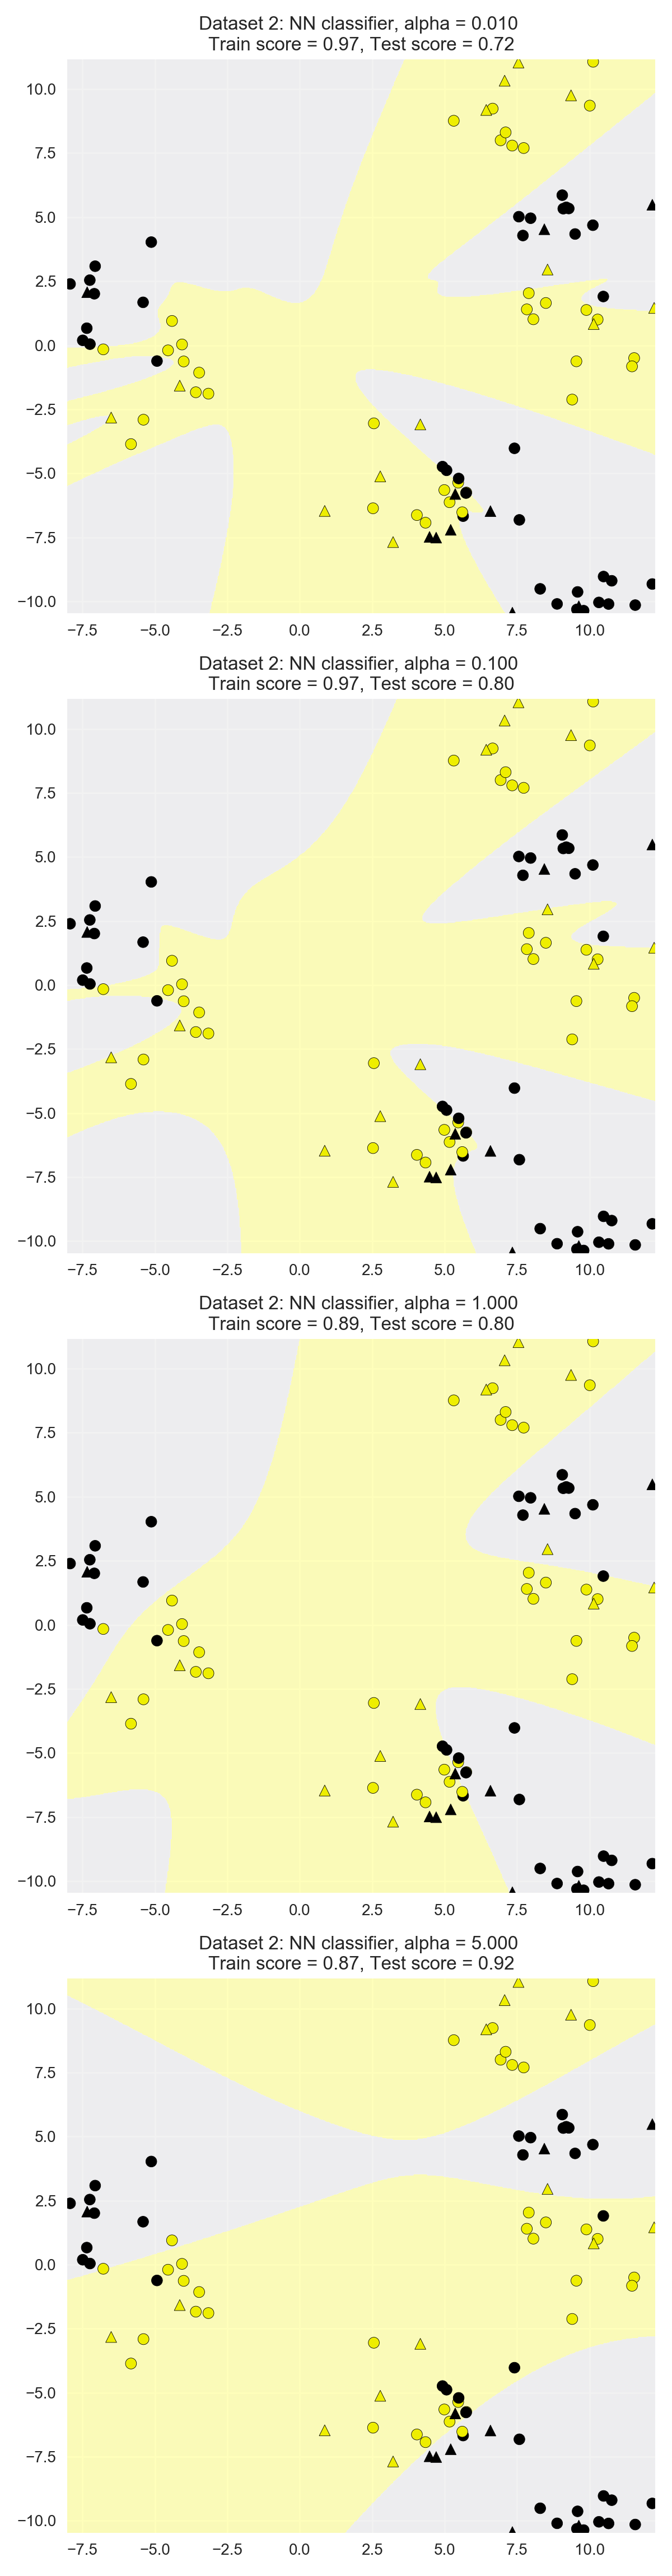

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'tanh',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 2: NN classifier, alpha = {:.3f} '.format(this_alpha)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()
    

#### The effect of different choices of activation function

<IPython.core.display.Javascript object>


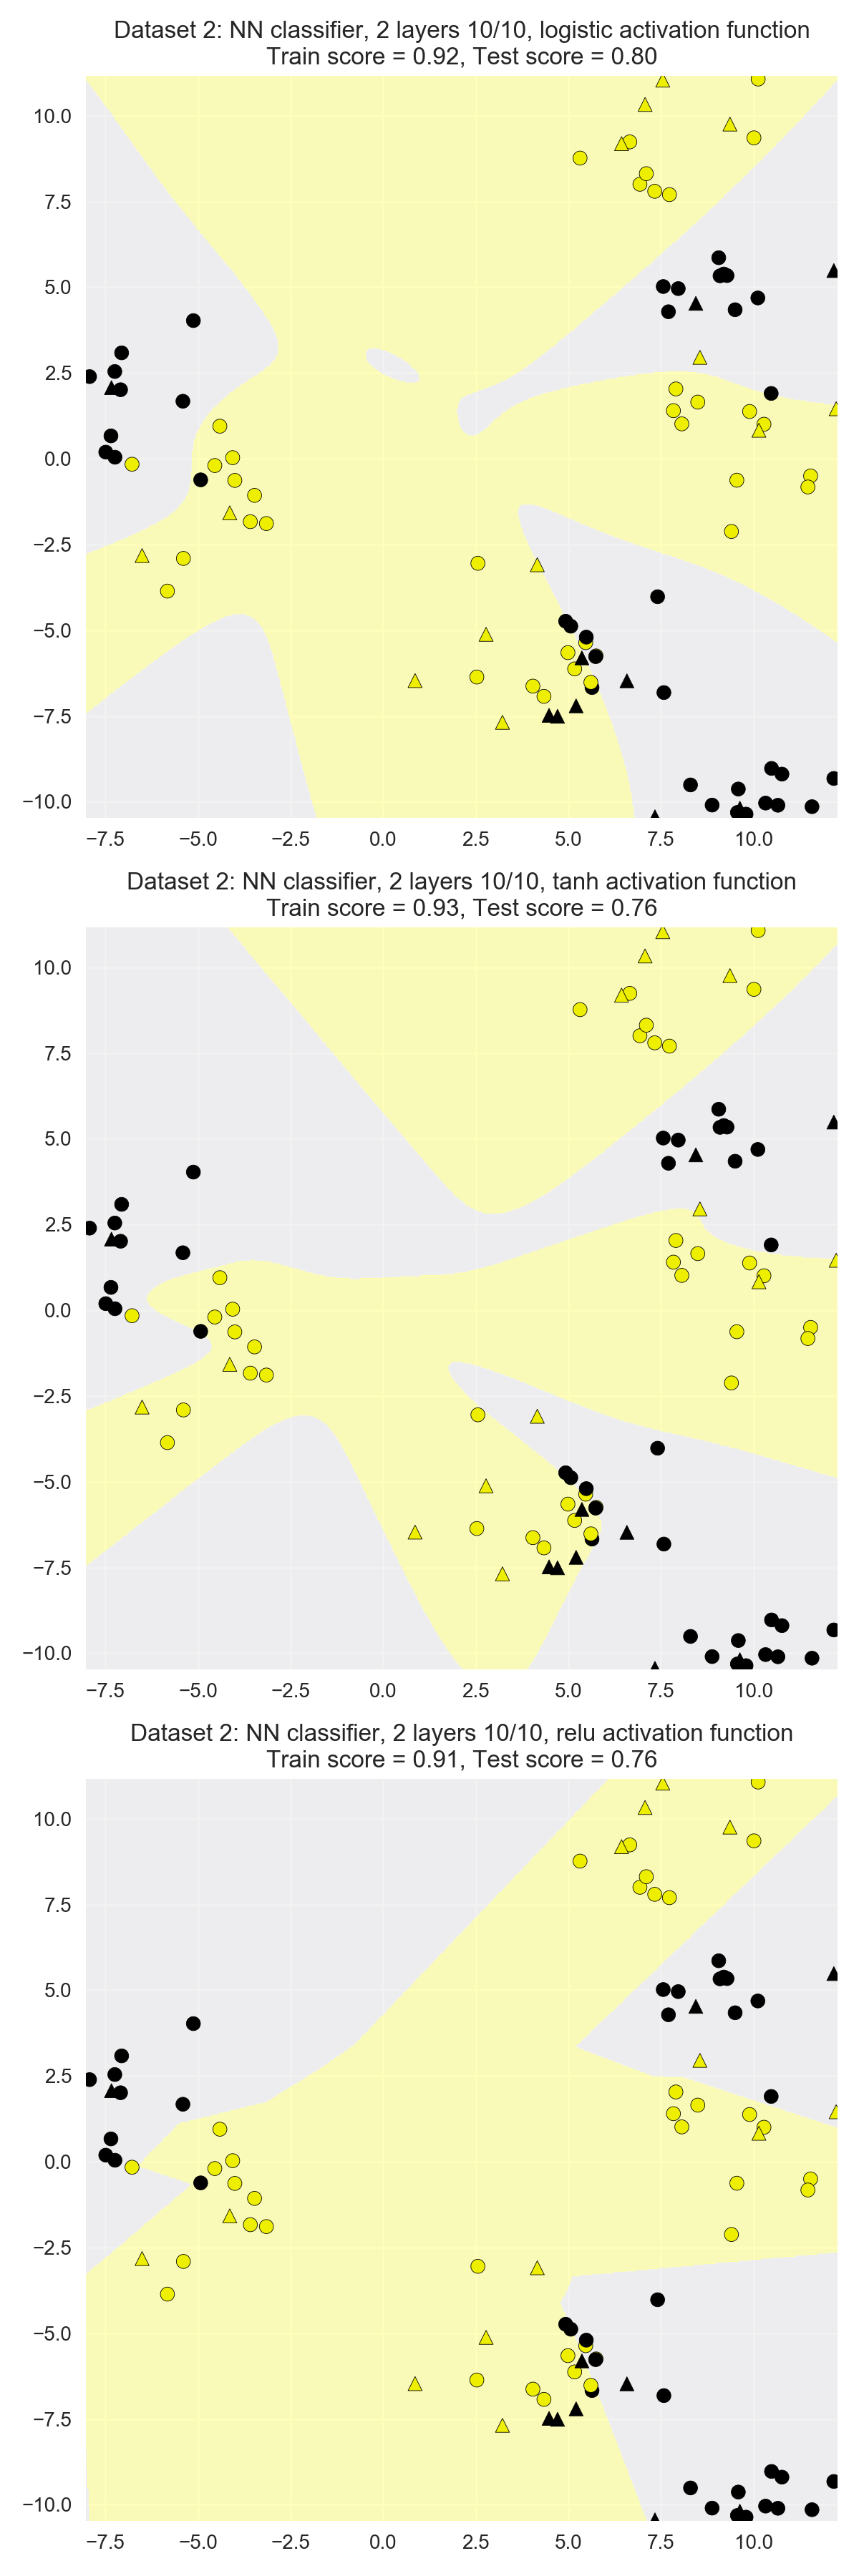

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

for this_activation, axis in zip(['logistic', 'tanh', 'relu'], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = this_activation,
                         alpha = 0.1, hidden_layer_sizes = [10, 10],
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 2: NN classifier, 2 layers 10/10, {} \
activation function'.format(this_activation)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Neural networks: Regression

As with other supervised learning models, like regularized regression and support vector machines. It can be critical, when using neural networks, to properly normalize the input features. 

Let's apply the multi-layer perceptron to the breast cancer data set. And notice that we first apply the ```MinMaxScaler```, to **pre-process the input features**. Here we'll combine a more complex network, using 2 hidden layers with 100 units each. With a higher regularization setting of alpha at 5.0, and using the lgbfs solver again. You can see, that with this multi-layer perceptron, both the training and test set accuracy are among the highest we have obtained on this data set. 

#### Application to real-world dataset for classification

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes = [100, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97


Like many of the other supervised learning methods we've seen, you can also use multi-layer perceptrons for regression, as well as classification. 


**We're including MLP regression here, as an example, for two reasons. First, because MLP regression may be useful for some regression problems on its own. But more generally, because some deep learning problems are regression problems. And so, as with classification, using multi-layer perceptrons is a good starting point to learn about the more complex architectures used for regression in deep learning.**

Here's the example of a simple MLP regression model, in our notebook. You use the multi-layer perceptron regressor by importing the MLPRegressor class from the sklearn.neural_network module, and then creating the ```MLPRegressor``` object. When creating the object here, we're setting the number of hidden layers and units within each hidden layer. Using the same hidden_layer_sizes parameter that we used for classification. This example uses two hidden layers, with 100 hidden nodes each. This notebook code has a loop that cycles through different settings of the activation function parameter, and the alpha parameter for L2 regularization. 

Here we've included regression results that use, in the top row, the hyperbolic tangent activation function. And in the bottom row, the relu activation function. You can see the smoothness of the activation function somewhat influences the smoothness of the corresponding regression results. Along the columns, the plots also show the effect of using different alpha settings, to increase the amount of L2 regularization from left to right. Again, as with classification, the effect of increasing the amount of L2 regularization, by increasing alpha. Is to constrain the regression to use simpler and simpler models, with fewer and fewer large weights. You can see this effect for both activation functions, in the top and bottom rows. The regression line on the left has higher variance than the much smoother, regularized model on the right. 

<img src="module4_NN_9.png" alt="jupyter" style="width: 600px;"/> 

<IPython.core.display.Javascript object>


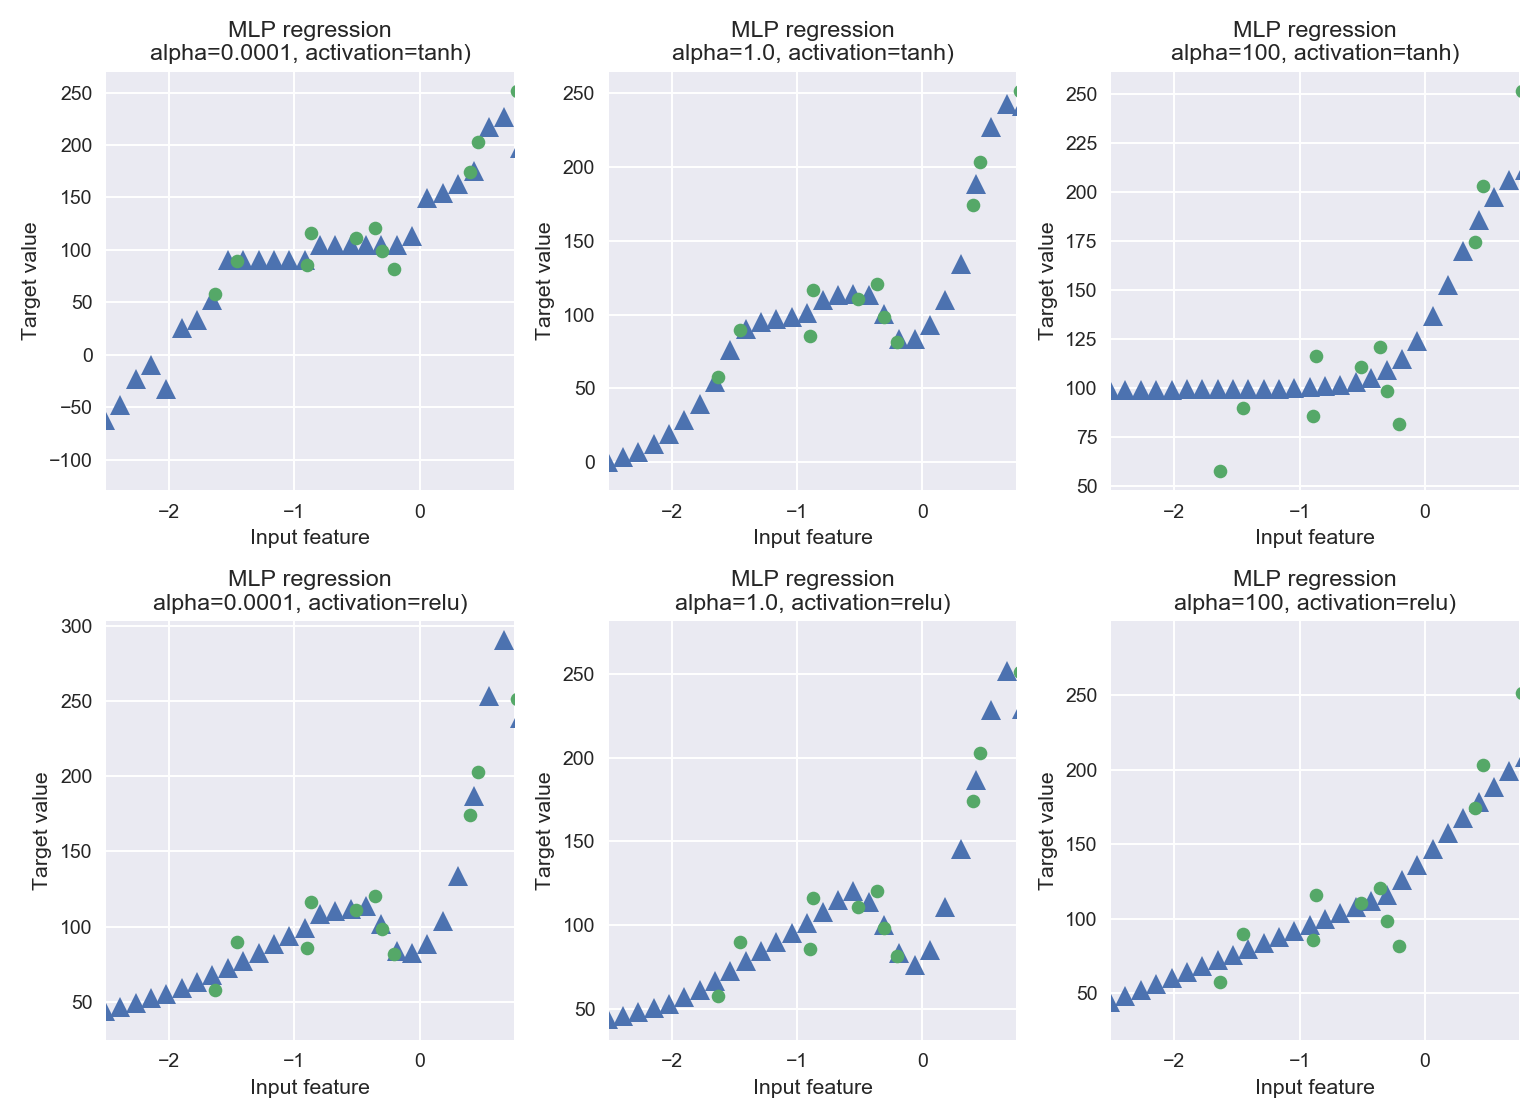

In [24]:
from sklearn.neural_network import MLPRegressor

fig, subaxes = plt.subplots(2, 3, figsize=(11,8), dpi=70)

X_predict_input = np.linspace(-3, 3, 50).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X_R1[0::5], y_R1[0::5], random_state = 0)

for thisaxisrow, thisactivation in zip(subaxes, ['tanh', 'relu']):
    for thisalpha, thisaxis in zip([0.0001, 1.0, 100], thisaxisrow):
        mlpreg = MLPRegressor(hidden_layer_sizes = [100,100],
                             activation = thisactivation,
                             alpha = thisalpha,
                             solver = 'lbfgs').fit(X_train, y_train)
        y_predict_output = mlpreg.predict(X_predict_input)
        thisaxis.set_xlim([-2.5, 0.75])
        thisaxis.plot(X_predict_input, y_predict_output,
                     '^', markersize = 10)
        thisaxis.plot(X_train, y_train, 'o')
        thisaxis.set_xlabel('Input feature')
        thisaxis.set_ylabel('Target value')
        thisaxis.set_title('MLP regression\nalpha={}, activation={})'
                          .format(thisalpha, thisactivation))
        plt.tight_layout()

On the positive side, beyond these simple examples we've shown here. Neural networks form the basis of advanced learning architectures. That capture complex features, and give state-of-the-art performance on an increasingly wide variety of difficult learning tasks. From world-championship play for the game of Go, to detailed and robust recognition of objects and images. However, with this increased power, come increased costs. This larger and more complex models typically require significant volumes of data, computation, and training time to learn. 

In addition, careful **pre-processing of the input data is needed, to help ensure fast, stable, meaningful solutions to finding the optimal set of weights**. In general, neural networks are a good choice, when the **features are of similar types**. For example, all derived from the pixels of an image. And less of a good choice, when the features are of very different types. 

<img src="module4_NN_10.png" alt="jupyter" style="width: 600px;"/> 


Finally, let's review the key parameters for the multi-layer perceptron in scikit-learn, that can be used to control model complexity. 

* The main way to control model complexity for the MLP, is to **control the hidden unit size and structure**. Using the ```hidden_layers_sizes``` parameter that controls the number of hidden layers, and the number of units within each layer. 

* ```alpha``` controls the amount of regularization that helps constrain the complexity of the model, by constraining the magnitude of model weights. 

* Finally, you can experiment with at least three different choices for the nonlinear activation function, by using the ```activation``` parameter. Earlier, we saw the solver parameter, for specifying the algorithm that learns the network weights. 

<img src="module4_NN_11.png" alt="jupyter" style="width: 600px;"/> 

*Solver* is the **algorithm that actually does the numerical work of finding the optimal weights**. And one intuitive way of visualizing this process. Is that all of the solver algorithms have to do a kind of hill-climbing in a very bumpy landscape, with lots of local minima. Where each local minimum corresponds to a locally optimal set of weights. That is, a choice of weight setting that's better than any nearby choices of weights. So across this whole landscape of very bumpy local minima. Some will have higher validation scores on the test data, and some will have lower. So depending on the initial random initialization of the weights, and the nature of the trajectory in the search path that a solver takes through this bumpy landscape. The solver can end up at different local minima, which can have different validation scores. The default solver, ```adam```, tends to be both efficient and effective on *large data sets*, with thousands of training examples. For *small data sets*, like many of the ones we use in these examples, the ```lbfgs``` solver tends to be faster, and find more effective weights. You can find further details on these more advanced settings in the documentation for scikit-learn. 


<a id="revise"></a> 
### Material to revise

* This tutorial by Ophir Tanz and Cambron Carter is a fun high-level math-free tutorial on neural networks and in particular, goes into more depth on convolutional neural networks - a form of neural network with multiple layers of processing that forms the basis for many deep learning systems today (see the Deep Learning lecture for more details).

[Carter, C., & Tanz, O. (2017, April 13). Neural networks made easy. Retrieved May 10, 2017]( https://techcrunch.com/2017/04/13/neural-networks-made-easy/)

* This neural network simulation by Daniel Smilkov and Shan Carter lets you play with neural networks in your browser. See the effect of different parameter settings and network configurations on a choice of difficult example classification problems.The "output" on the right shows the "training loss" and "test loss". Loss is an evaluation metric that is related to the number of errors made for each example on the training or test set - so lower loss numbers are better. (In technical terms, for neural networks the loss is usually negative log-likelihood for classification, and residual sum of squares for regression.) To show decision boundaries more clearly, along with the test data, click the two checkboxes marked "Show test data" and "Discretize output" in the lower right of the window. To access the simulation, click [here](http://playground.tensorflow.org/)

<a id="deeplerning"></a> 

## Deep Learning (Optional)

As we discussed in the first week of the course, one of the key challenges in machine learning is **finding the right features to use as input to a learning model for a particular problem. This is called feature engineering** and can be part art, and part science. It can also be the single most factor in doing well on a learning task. Sometimes, in fact, more often more important than the choice of the model itself. We'll discuss this further in the last week of the course. Because of the difficulty of feature engineering, there's been a lot of research on what's called **feature learning or feature extraction algorithms** that can find good features automatically. This brings us to deep learning. 

* At a high-level, one of the advantages of deep learning is that it includes a sophisticated automatic featured learning phase as part of its supervised training. 

* Moreover, deep learning is called deep. Because this feature extraction typically doesn't use just one feature learning step, but a hierarchy of multiple feature learning layers. Each feeding into the next. 

<img src="module4_DeepL_1.png" alt="jupyter" style="width: 600px;"/> 

Here's one simplified example of what a deep learning architecture might look like in practice for an *image recognition task*. In this case, digit recognition. Recognizing a handwritten digit from zero to nine, for example. You can see the automatic feature extraction step made up of hierarchy of feature layers. Each of which is based on a network that does **convolution which can be thought of as a filter for a specific pattern followed by a subsampling step, also known as pooling that can detect a translated or rotated version of that feature anywhere in the image**. So that features are detected properly for the final classification step, which is implemented as a fully connected network. **The subsampling step also has the effect of reducing the computational complexity of the network**. Depending on the properties of the object we want to predict, for example, If we care only about the presence of the object in the image compared to let's say, specific location, the subsampling part of the architecture may or may not be included and this is only one example of a deep learning architecture. The size, structure and other properties may look very different. Depending on the specific learning problem. 

<img src="module4_DeepL_2.png" alt="jupyter" style="width: 600px;"/> 

This image from a paper by Honglak Lee and colleagues at the University of Michigan shows an illustration of multilayer feature learning for face recognition. Here there are three groups from left to right corresponding to first, second and third stages of feature learning. The matrix at each stage shows a set of image features with one feature per square. Each feature can be thought of as a detector or filter, that lights up when that pattern is present in the underlying image. 

* The first layer of their deep learning architecture extracts the most primitive low-level features, such as edges and different kinds of blobs. 
* The second layer creates new features from combinations of those first layer features. For faces, this might correspond to key elements that capture shapes of higher level features like noses or eyes. 
* The third layer in turn, creates new features from combinations of the second layer of features. Forming still higher level features that capture typical face types and facial expressions. Finally, all of these features are used as input to the final supervised learning step, namely the face classifier. 

<img src="module4_DeepL_3.png" alt="jupyter" style="width: 600px;"/> 

Here are the feature layers that result from training on different types of objects, cars, elephants, chairs and a mixture of objects. These kinds of complex features can't be learned from a small number of layers. Advances in both algorithms and computing power allow current deep learning systems to train architectures that could have dozens of layers of nonlinear, hierarchical features. It turns out that the human brain does something quite related to this when processing visual information. There are specific neurocircuits that first do low-level feature extraction, such as edge detection and finding the frequency of repeated patterns which are then used to compute more sophisticated features to help estimate things like simple shapes and their orientation or whether a shape is in the foreground or background. Followed by further layers of higher level visual processing that support more complex tasks, such as face recognition and interpreting the motion of multiple moving objects. 

<img src="module4_DeepL_4.png" alt="jupyter" style="width: 600px;"/> 

* On the **position** side, deep learning systems have achieved impressive gains and have achieved state-of-the-art performance on many difficult tasks. 

* Deep learning's automatic feature extraction mechanisms also reduce the need for human guesswork in finding good features. Finally, with current software, deep learning architectures are quite flexible. It could be adapted for different tasks and domains. 

* On the **negative** side, however, deep learning can require very large training sets and computing power. I'm not going to limit its practicality in some scenarios. 
* The complexity of implementation could be considered as one of the negatives of deep learning and this is the reason that a number of sophisticated high-level software packages have been developed to assist in the development of deep learning architectures.

Also, despite the faces example we saw earlier which gave clear easy to interpret features in most cases, often the features and weights of typical deep learning systems are not nearly so easy to interpret. That is, it's not clear why or what features led a deep learning system to make a particular prediction. 

<img src="module4_DeepL_5.png" alt="jupyter" style="width: 600px;"/> 

Well, scikit-learn with the MLP classifier and MLP regressor classes provides a useful environment to learn about and apply simple neural networks. If you're interested in getting a deep understanding of deep learning and the software tools required to use it, we've provided some links to additional resources. 

In particular, software packages usable with Python include **Keras** and **Lasagne** which in turn use libraries that include **TensorFlow** and **Theano**. 

Deep learning typically requires not only significant volumes of data for training, but also significant computation. Turns out that the processor inside video cards called GPUs are high-performance graphical processing units are well-suited to large scale, highly paralyzed high-performance computing. Because they can do high key underlying like matrix multiplication very quickly. This is because they are designed to process large volumes of data from memory 
as you might do for streaming video, for example, and they have many high speed registers that can operate in parallel on this data. Unlike scikit-learn which cannot currently exploit GPUs, these deep learning libraries could make full use of GPU clusters for large scale learning of deep learning architectures. 

<img src="module4_DeepL_6.png" alt="jupyter" style="width: 600px;"/> 

<a id="revise2"></a> 
### Material to revise

This self-contained tutorial by Tim Dettmers covers the key high-level concepts of deep learning and reinforces the basic concepts we covered in the Neural Networks and Deep Learning lectures. There are multiple parts - Part 1 is less technical while Parts 2-4 go into more detail on algorithms.

The link to access Part 1 is [here](https://devblogs.nvidia.com/parallelforall/deep-learning-nutshell-core-concepts/)

Deep Learning in a Nutshell: Core Concepts. (2016, September 08). Retrieved May 10, 2017.

This short article is an example of how deep learning is being used in healthcare.

[Assisting Pathologists in Detecting Cancer with Deep Learning](https://research.googleblog.com/2017/03/assisting-pathologists-in-detecting.html)

Posted by Martin Stumpe (Technical Lead) and Lily Peng (Product Manager), Google Research Blog

<a id="leakage"></a> 

## Data Leakage (Optional)

In data science, the term data leakage sometimes just referred to as **leakage**, describes the situation where the **data you're using to train the machine learning algorithm happens to include unexpected extra information about the very thing you're trying to predict. Basically, leakage occurs any time that information is introduced about the target label or value during training that would not legitimately be available during actual use**. 

Maybe the simplest example of data leakage would be if we included the true label of a data instance as a feature in the model. The model would learn the equivalent of, if this object is labeled as an apple, predict it's an apple. Another clear example of data leakage that we've seen before is having test data accidentally included in the training data which leads to over fitting. 

However, data leakage can happen for many other reasons too, often in ways that are quite subtle and hard to detect. When data leakage does occur, it typically causes results during your model development phase that are too optimistic, followed by the nasty surprise of disappointing results after the prediction model is actually deployed and evaluated on new data. In other words, leakage can cause your system to learn a sub optimal model that does much worse in actual deployment than a model developed in a leak free setting. 

<img src="module4_Leakage_1.png" alt="jupyter" style="width: 600px;"/> 

So leakage can have dramatic implications in the real world ranging from the financial cost of making a bad monetary and engineering investment in something that doesn't actually work, to system failures that hurt customers perception of your system's quality or impact to the company's brand. For these reasons, **data leakage is one of the most serious and widespread problems in data mining and machine learning and something that as a machine learning practitioner, you must always be on guard against**. So now, we'll cover what data leakage is, why it matters, how it can be detected and how you might avoid it in your applications. 

As an aside, this term data leakage is also used in the field of data security to mean the unauthorized transfer of information outside of a secure facility like a data center. However, in some ways this security based meaning is actually somewhat appropriate for our machine learning setting, given the importance of keeping information about the prediction securely separated from the training and model development phase. 


Let's look at some more subtle examples of data leakage problems. One classic case happens when information about the future that would not legitimately be available in actual use, is included in the training data. 

* Suppose you are developing a retail website and building classifier to predict whether the user is likely to stay and view another page or leave the site. If the classifier predicts they're about to leave, the website might pop up something that offers incentives to continue shopping. An example of a **feature that contains leaked information would be the user's total session length or the total number of pages they viewed during their visit** to the site. This total is often added as a new column during the post-processing phase of the visit log data, for example. This feature has information about the future namely, how many more visits the user is going to make. That's impossible to know in an actual deployment. A **solution is to replace the total session length feature with a page visit in-session feature that only knows the total pages visited so far in the session, and not how many are remaining**. 

* The second example of leakage might involve trying to **predict if a customer on a bank's website was likely to open an account**.If the user's record contains an account number field, it might normally be empty for users still on the process of exploring the site but eventually it's filled in once the user does open an account. **Clearly the user account field is not a legitimate feature that should be used in this case, because it may not be available at the time the user is still exploring the site**. 

* Another example of future information leaking in the past might be, if you are developing a diagnostic test to predict a particular medical condition. The existing patient data set might contain a binary variable that happens to mark whether or not the patient had surgery for that condition. Obviously, such a variable would be highly predictive of the medical condition. There are many other ways predictive information could leak into this feature set. There might be a certain combination of missing diagnosis codes that was very indicative of the medical condition. But again, these would not be legitimate to use since that information isn't available while a patient's condition is still being studied. 

* Finally, another example in the same patient is that it might involve the form of the patient ID. The ID might be assigned depending on a particular diagnosis path. In other words, the ID could be different if it's the result of a visit to a specialist, where the initial doctor determined that the medical condition was likely.  This last example is a great illustration of the fact that there are many different ways data leakage could occur in a training set and in fact, it's often the case that more than one leakage problem is present at once. Sometimes, fixing one leaking feature can reveal the existence of a second one, for example.

<img src="module4_Leakage_2.png" alt="jupyter" style="width: 600px;"/> 

As a guide, here are some additional examples of data leakage. We can divide leakage into two main types. **Leakage and the training data; typically where test data or future data gets mixed into the training data**, and **leakage in features, where something highly informative about the true label somehow gets included as a feature**. 

* One very important cause of data leakage is **performing some kind of pre-processing on the entire dataset** whose results influence what is seen during training. This can include such scenarios as computing parameters for normalizing and rescaling or finding minimum and maximum feature values to detect and remove outliers and using the distribution of a variable across the entire dataset to estimate missing values in the training set, or perform feature selection. 

* Another critical need for caution occurs when working with time series data, **where records for future events are accidentally used to compute features for a particular prediction**. The session length example that we saw, was one instance of this but more subtle effects can occur if there are errors in data gathering or missing value indicators. If a feature relates to collecting at least one record in a time span, the presence of an error may give away information about the future. In other words, that no further observations are to be expected. 

* Leakage in features includes the case where we have a variable like *diagnosis ID* and a *patient record* that we remove but neglect to also remove other variables known as proxy variables that contain the same or similar information. The patient ID in the case where the ID number had clues about the nature of the patient's diagnosis due to the admission process, was an example of this. In some cases, data set records are intentionally randomized or certain fields anonymized that contain specific information about a user such as, their name, location and so on. Depending on the prediction task, undoing this anonymization can reveal user or other sensitive information that is not legitimately available in actual use. 

<img src="module4_Leakage_3.png" alt="jupyter" style="width: 600px;"/>

**Finally, any of the above examples we've discussed here could be present in a third party dataset that gets joined to the training set as an additional source of features. So, always be aware of the features in such external data and their interpretation and origin**. 

**So how can you detect and avoid data leakage in your applications?**

* Before building the model, exploratory data analysis can reveal surprises in the data. For example, **look for features very highly correlated with the target label or value**. An example of this, from the medical diagnostic example, might be the binary feature that indicated a patient had a particular surgical procedure for the condition. That might be extremely highly correlated with a particular diagnosis. 

After building the model:
* look for a surprising feature behavior in the fitted model such as extremely high feature weights or very high information games associated with variable.

* look for overall surprising model performance. If your model evaluation results are substantially higher than the same or similar problems and similar datasets, then look closely at the instances or features that have most influence on the model. 

* One more reliable check for leakage but also potentially expensive, is to do a limited real world deployment of the trained model to see if there's a big difference between the estimated performance suggested by the model's training and development results and the actual results. This check that the model is generalizing well to new data is useful, but may not give much immediate insight into if or where the leakage is happening or if any drop in performance is due to other reasons like classical over fitting.


<img src="module4_Leakage_4.png" alt="jupyter" style="width: 600px;"/>

There are **practices you can follow to help reduce the chance of data leakage in your application**. 

* One important rule is to make sure that you **perform any data preparation within each cross-validation fold, separately**. In other words, if you're scaling or normalizing features, any statistics or parameters that you estimate for this should only be based on the data available in the cross-validation split and not the entire data set. You should also make sure that you use these same parameters on the corresponding held out test fold. 

* If you're working with time series data, keep **track of the time stamp** that's associated with processing a particular data instance, such as a user's click on a webpage and make sure any data used to compute features for this instance does not include records with a later time than the cutoff value. This will help ensure you're not including information from the future in your current feature calculations or training data. 

* If you have enough data, consider splitting off a completely separate test set before you even start working with a new dataset, and then evaluating your final model and this test data only as a very last step. The goal here is similar to doing a real world deployment to check that your train model does generalize reasonably well to new data. If there's no significant drop in performance, great. But if there is, leakage maybe one contributing factor, along with the usual suspects like classical over fitting. 

<img src="module4_Leakage_5.png" alt="jupyter" style="width: 600px;"/>

For more real world examples, analysis and guidance about preventing data leakage, you can take a look at the optional readings provided in the lesson plan. 

<a id="revise3"></a> 
### Material to revise

* This fun, less-technical read from Colin Fraser reinforces the material in the Data Leakage lecture to provide further explanation and examples on detecting and avoiding data leakage in your machine learning applications.

Here's the link to the [article](https://medium.com/@colin.fraser/the-treachery-of-leakage-56a2d7c4e931)

* In 2013 a machine learning competition offered a prize for the most accurate detection of right whale calls based on audio data. The organizers soon discovered data leakage problems in the first release of the dataset, and this article explains what happened. It's a short but interesting article that serves as an excellent example of how subtle or not-so-subtle leakage can occur in specific features. https://www.kaggle.com/c/the-icml-2013-whale-challenge-right-whale-redux/discussion/4865#25839#post25839

* This optional reading is intended mainly for software engineers who want to build and deploy machine learning applications in production - especially at scale. The only background knowledge required are the basic machine learning concepts we've covered so far in this course. Written by Google's Dr. Martin Zinkevich, it walks through a set of software engineering best practices for designing and deploying machine learning in software systems - based on years of practical experience at Google. http://martin.zinkevich.org/rules_of_ml/rules_of_ml.pdf


In [26]:
!find . -maxdepth 1 -not -type d

./.DS_Store
./.README.md.un~
./2007GuideControlledExperiments.pdf
./addresses.csv
./adspy_shared_utilities.py
./adspy_shared_utilities_original_Jul12.py
./classification_report.png
./Classifier Visualization.ipynb
./Colour_source.png
./CommViolPredUnnormalizedData.txt
./Data_split.png
./Data_split_porp.png
./fraud_data.csv
./fruit_data_with_colors.txt
./KNN_explanation.png
./KNN_explanation_2.png
./KNN_explanation_3.png
./KNN_explanation_4.png
./KNN_explanation_5.png
./KNN_regclass_1.png
./KNN_regclass_2.png
./KNN_regclass_3.png
./KNN_regclass_4.png
./KNN_regclass_5.png
./KNN_regclass_6.png
./latlons.csv
./Module 1.ipynb
./Module 2.ipynb
./Module 3.ipynb
./Module 4.ipynb
./module2_1.png
./module2_2.png
./module2_3.png
./module2_4.png
./module2_5.png
./module2_6.png
./module2_7.png
./module2_8.png
./module2_9.png
./module2_crossvalidation_1.png
./module2_crossvalidation_2.png
./module2_crossvalidation_3.png
./module2_crossvalidation_4.png
./module2_crossvalidation_5.png
./module2_crossv

In [27]:
!ls readonly

adspy_temp.dot     polynomialreg1.png


In [8]:
!cp ./Module 2.ipynb readonly/Module 2.ipynb

cp: target ‘2.ipynb’ is not a directory
